# Notebook for alignment analysis

Imports

In [1]:
import time
import os
import importlib

from pprint import pprint
from collections import defaultdict
from pathlib import Path
import re
import json

from more_itertools import grouper
from itertools import islice, chain, zip_longest, repeat

import numpy as np
import pandas as pd

import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

import scipy
from scipy import io
from scipy.signal import convolve
from scipy.sparse import coo_matrix, csr_matrix
from scipy.stats import pearsonr, spearmanr
from scipy.cluster.hierarchy import cut_tree

from statsmodels.stats import multitest

from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder

import pyBigWig
import pysam

from Modules import utils, plot_utils

Useful global variables

In [2]:
importlib.reload(utils)
importlib.reload(plot_utils)
data_dir = "../shared_folder"
writing_dir = "../shared_folder"
# writing_dir='../'
prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]
# plt.rcParams.update({'axes.labelsize': 16})
with open("/home/alex/shared_folder/Human/T2T-CHM13v2.0_NCBI2UCSC.txt") as f:
    T2T_to_ucsc = dict(line.split() for line in f.readlines())

Split bam into multiple files

In [69]:
# bam_file = "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/HN00205099_RawFASTQ_RPE1_WTH3K9me3_paired.sorted.bam"
# n_splits = 10
# utils.split_bam(bam_file, n_splits)

0 reads have no mate


In [4]:
original_bam_file = "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/HN00205099_RawFASTQ_RPE1_WTH3K9me3_paired.sorted.bam"
bam_file_splits = [
    f"/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/HN00205099_RawFASTQ_RPE1_WTH3K9me3_paired_{i}.sorted.bam"
    for i in range(10)
]
cpt = 0
first = None
for bam_file in [original_bam_file] + bam_file_splits:
    with pysam.AlignmentFile(bam_file, "rb") as f:
        mapped = f.mapped + f.unmapped - f.nocoordinate
        if first is None:
            first = mapped
        cpt += mapped
        print(mapped)
print(cpt - first)

1011101418
101098558
101123348
101100408
101106698
101136626
101104634
101110892
101109942
101112736
101097576
1011101418


Extract repeat positions

In [3]:
def get_all_bowtie2_pos_by_query(bamfile: str, paired: bool):
    with pysam.AlignmentFile(bamfile, "rb") as f:
        pos = {}
        for read in f.fetch():
            rname = read.query_name
            chr_id = read.reference_name
            start = read.reference_start
            bt2_align_val = read.tags[0][1]
            if rname not in pos:
                pos[rname] = {}
            if paired:
                nstart = read.next_reference_start
                tlen = abs(read.template_length)
                if not read.is_reverse:
                    stop = start + tlen
                    if (chr_id, start, stop) not in pos[rname]:
                        pos[rname][(chr_id, start, stop)] = []
                    pos[rname][(chr_id, start, stop)].append(bt2_align_val)
                else:
                    nstop = nstart + tlen
                    pos[rname][(chr_id, nstart, nstop)].append(bt2_align_val)
            else:
                qlen = read.query_alignment_length
                stop = start + qlen
                pos[rname][(chr_id, start, stop)] = bt2_align_val
    return pos

In [47]:
pos = get_all_bowtie2_pos_by_query(
    "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/RNAg-Alu31Rev.sorted.bam",
    paired=False,
)
pos

{'RNAg-Alu31Rev': {('NC_060925.1', 12305, 12320): 0,
  ('NC_060925.1', 17045, 17060): 0,
  ('NC_060925.1', 23935, 23950): 0,
  ('NC_060925.1', 31145, 31160): 0,
  ('NC_060925.1', 40363, 40378): -6,
  ('NC_060925.1', 44177, 44192): 0,
  ('NC_060925.1', 51451, 51466): -6,
  ('NC_060925.1', 52492, 52507): 0,
  ('NC_060925.1', 55618, 55633): -6,
  ('NC_060925.1', 59804, 59819): 0,
  ('NC_060925.1', 60903, 60918): 0,
  ('NC_060925.1', 65228, 65243): 0,
  ('NC_060925.1', 66970, 66985): -6,
  ('NC_060925.1', 67740, 67755): -6,
  ('NC_060925.1', 69812, 69827): 0,
  ('NC_060925.1', 79733, 79748): -6,
  ('NC_060925.1', 87349, 87364): 0,
  ('NC_060925.1', 118339, 118354): 0,
  ('NC_060925.1', 128317, 128332): 0,
  ('NC_060925.1', 136845, 136860): 0,
  ('NC_060925.1', 139039, 139054): 0,
  ('NC_060925.1', 145495, 145510): 0,
  ('NC_060925.1', 146338, 146353): -6,
  ('NC_060925.1', 147315, 147330): 0,
  ('NC_060925.1', 147525, 147540): -6,
  ('NC_060925.1', 157770, 157785): -6,
  ('NC_060925.1', 16

In [48]:
print(len(pos))
for repeat_element, positions in pos.items():
    partial_positions = list(positions.keys())
    exact_positions = [
        pos
        for pos, bt2_align_val in positions.items()
        if np.all(np.array(bt2_align_val) == 0)
    ]
    print(repeat_element, len(partial_positions), len(exact_positions))
    # for bam_list, suffix in zip(
    #     [partial_positions, exact_positions], ["partial", "exact"]
    # ):
    #     with open(
    #         f"/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/T2T_{repeat_element}_positions_{suffix}.bed",
    #         "w",
    #     ) as f:
    #         for chr_id, start, stop in bam_list:
    #             f.write(f"{chr_id}\t{start}\t{stop}\n")

1
RNAg-Alu31Rev 645510 298131


In [49]:
for repeat_element, positions in pos.items():
    print(repeat_element, np.unique(list(positions.values()), return_counts=True))

RNAg-Alu31Rev (array([-6,  0]), array([347379, 298131]))


In [4]:
intervals_dict = utils.parse_bed_peaks(
    "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/T2T_RNAg-Alu31Rev_positions_partial.bed"
)
intervals_dict2 = utils.parse_bed_peaks(
    "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/T2T_RNAg-Alu31Rev-bis_positions_partial.bed"
)
n_ip2, n_ip1, n_match = 0, 0, 0
for chr_id, intervals in intervals_dict.items():
    idx1 = utils.indices_from_peaks(intervals)
    idx2 = utils.indices_from_peaks(intervals_dict2[chr_id])
    mask = np.zeros(max(np.max(idx1), np.max(idx2)) + 1, dtype=int)
    mask[idx1] += 1
    mask[idx2] += 1
    n_ip1 += len(idx1)
    n_ip2 += len(idx2)
    n_match += (mask == 2).sum()
print(
    f"{n_ip1} bases in intervals1, {n_ip2} bases in intervals2 and {n_match} bases in overlap"
)
print(
    f"bases: {100*n_match/n_ip1}% in intervals1 match {100*n_match/n_ip2}% in intervals2"
)

9682650 bases in intervals1, 6892280 bases in intervals2 and 5169216 bases in overlap
bases: 53.38637666341342% in intervals1 match 75.0000870539212% in intervals2


In [3]:
bedfiles = {
    "D4Z1": "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/T2T_D4Z1_positions_exact2.bed",
    "Alpha": "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/T2T_Alpha_positions_exact2.bed",
    "Alu": "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/T2T_Alu_positions_exact2.bed",
    "RNAg-Alu31Rev": "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/T2T_RNAg-Alu31Rev_positions_exact.bed",
    "RNAg-Alu31Rev-bis": "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/T2T_RNAg-Alu31Rev-bis_positions_exact.bed",
}
for repid, bedfile in bedfiles.items():
    print(repid)
    df = pd.read_csv(bedfile, sep="\t", header=None)
    print(df.groupby(0).count())

D4Z1
               1    2
0                    
NC_060928.1  920  920
Alpha
                1     2
0                      
NC_060925.1  1515  1515
NC_060929.1   754   754
NC_060943.1    70    70
Alu
               1    2
0                    
NC_060925.1  511  511
NC_060926.1  448  448
NC_060927.1  394  394
NC_060928.1  355  355
NC_060929.1  325  325
NC_060930.1  303  303
NC_060931.1  288  288
NC_060932.1  230  230
NC_060933.1  278  278
NC_060934.1  261  261
NC_060935.1  257  257
NC_060936.1  329  329
NC_060937.1  207  207
NC_060938.1  184  184
NC_060939.1  179  179
NC_060940.1  164  164
NC_060941.1  251  251
NC_060942.1  153  153
NC_060943.1  196  196
NC_060944.1  128  128
NC_060945.1   99   99
NC_060946.1   69   69
NC_060947.1  249  249
NC_060948.1   70   70
RNAg-Alu31Rev
                 1      2
0                        
NC_060925.1  25959  25959
NC_060926.1  21403  21403
NC_060927.1  17028  17028
NC_060928.1  13715  13715
NC_060929.1  14549  14549
NC_060930.1  15129  15129
NC_06

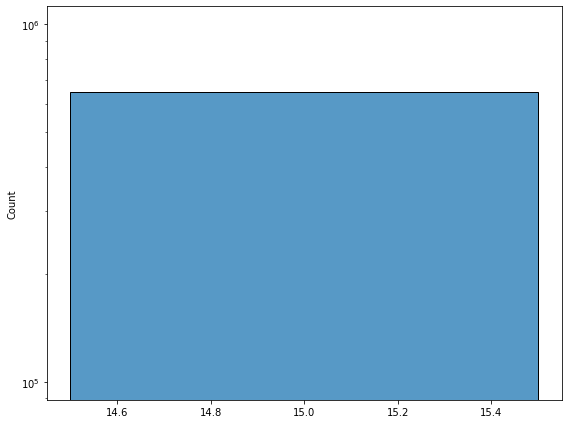

In [5]:
repid = "RNAg-Alu31Rev"
matching = "partial"
df = pd.read_csv(
    f"/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/T2T_{repid}_positions_{matching}.bed",
    sep="\t",
    header=None,
)
df.columns = ["chr", "start", "stop"]
fig, ax = plt.subplots(1, 1, figsize=(8, 6), facecolor="w", layout="tight")
sns.histplot(df["stop"] - df["start"], discrete=True, ax=ax)
ax.set_yscale("log")

In [175]:
df = df_nodup.copy()

In [6]:
to_remove = set()
to_add = set()
for chr_id in T2T_to_ucsc.keys():
    chrdf = df[df["chr"] == chr_id]
    (idxes,) = np.where(chrdf["start"][1:].array - chrdf["stop"][:-1].array < 0)
    print(chr_id, idxes)
    for idx in idxes:
        idxdf = chrdf.iloc[idx : idx + 2,].copy()
        idxdf["len"] = idxdf["stop"] - idxdf["start"]
        print(idxdf)
        if (
            idxdf.iloc[0, 1] != idxdf.iloc[1, 1]
            and idxdf.iloc[0, 2] != idxdf.iloc[1, 2]
            and (
                chrdf.iloc[idx + 2, 1] != idxdf.iloc[1, 1]
                or chrdf.iloc[idx + 2, 2] != idxdf.iloc[0, 2]
            )
        ):
            idxdf["crosslen"] = idxdf["stop"].array[::-1] - idxdf["start"].array
            subdf = idxdf.loc[:, "len":"crosslen"]
            argmin = np.unravel_index(np.argmin(subdf), subdf.shape)
            if argmin[1] == 1:  # max is in "crosslen"
                to_add.add(
                    (
                        chr_id,
                        idxdf.iloc[argmin[0], 1],
                        idxdf.iloc[(argmin[0] + 1) % 2, 2],
                    )
                )
                to_remove.add(idxdf.index[idxdf["len"].argmin()])
            print(idxdf)
            print(chrdf.iloc[idx : idx + 3,])
        # Remove the longest match
        to_remove.add(idxdf.index[(idxdf["len"]).argmax()])
print("number to remove", len(to_remove))
df_nodup = df.drop(labels=list(to_remove))
print("length after removing", len(df_nodup))
to_add_at_loc = {}
for chr_id, start, stop in to_add:
    subdf_nodup = df_nodup[(df_nodup["chr"] == chr_id)]
    first_over = np.argmax(subdf_nodup["start"] >= start)
    insert_loc = np.mean(subdf_nodup.iloc[first_over - 1 : first_over + 1].index)
    to_add_at_loc[insert_loc] = [chr_id, start, stop]
df_nodup = pd.concat(
    [
        df_nodup,
        pd.DataFrame(
            to_add_at_loc.values(), columns=df_nodup.columns, index=to_add_at_loc.keys()
        ),
    ]
)
df_nodup.sort_index(inplace=True)
df_nodup.index = np.arange(len(df_nodup))
print("length after adding", len(df_nodup))
# df_nodup.to_csv(
#     f"/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/T2T_{repid}_positions_{matching}_nodup.bed",
#     sep="\t",
#     header=None,
#     index=None,
# )

NC_060925.1 [6183]
              chr     start      stop  len
6183  NC_060925.1  16846029  16846044   15
6184  NC_060925.1  16846041  16846056   15
              chr     start      stop  len  crosslen
6183  NC_060925.1  16846029  16846044   15        27
6184  NC_060925.1  16846041  16846056   15         3
              chr     start      stop
6183  NC_060925.1  16846029  16846044
6184  NC_060925.1  16846041  16846056
6185  NC_060925.1  16848315  16848330
NC_060926.1 []
NC_060927.1 [14028]
                chr     start      stop  len
116804  NC_060927.1  63793043  63793058   15
116805  NC_060927.1  63793056  63793071   15
                chr     start      stop  len  crosslen
116804  NC_060927.1  63793043  63793058   15        28
116805  NC_060927.1  63793056  63793071   15         2
                chr     start      stop
116804  NC_060927.1  63793043  63793058
116805  NC_060927.1  63793056  63793071
116806  NC_060927.1  63794134  63794149
NC_060928.1 []
NC_060929.1 []
NC_060930.1 [246

In [24]:
for chr_id in T2T_to_ucsc.keys():
    chrdf = df_nodup[df_nodup["chr"] == chr_id]
    (idxes,) = np.where(chrdf["start"][1:].array - chrdf["stop"][:-1].array < 0)
    print(chr_id, idxes)

NC_060925.1 []
NC_060926.1 []
NC_060927.1 []
NC_060928.1 []
NC_060929.1 []
NC_060930.1 []
NC_060931.1 []
NC_060932.1 []
NC_060933.1 []
NC_060934.1 []
NC_060935.1 []
NC_060936.1 []
NC_060937.1 []
NC_060938.1 []
NC_060939.1 []
NC_060940.1 []
NC_060941.1 []
NC_060942.1 []
NC_060943.1 []
NC_060944.1 []
NC_060945.1 []
NC_060946.1 []
NC_060947.1 []
NC_060948.1 []


Extract fragment count by repeat

In [20]:
quantiles = pd.read_csv(
    "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/quantiles_INPUT_IP1_IP2.csv",
    index_col=0,
)
quantiles

,quantile_0.9,quantile_0.95,quantile_0.99,quantile_0.999
/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/D1145C44_trimmed_paired_T2T.bw,12.0,14.0,20.0,28.0
/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/D1145C43_trimmed_paired_T2T.bw,16.0,18.0,26.0,48.0
/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/HN00205099_RawFASTQ_RPE1_WTH3K9me3_paired_T2T.bw,123.0,139.0,181.0,348.0


In [37]:
bwfiles = {
    "Ctrl": "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/D1145C44_trimmed_paired_T2T.bw",
    "IP1": "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/D1145C43_trimmed_paired_T2T.bw",
    "IP2": "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/HN00205099_RawFASTQ_RPE1_WTH3K9me3_paired_T2T.bw",
}
sums = {}
clipped_sums = {}
for file_id, bwfile in bwfiles.items():
    filesum = 0
    clipped_filesum = 0
    with pyBigWig.open(bwfile) as bw:
        for chr_id in bw.chroms():
            values = bw.values(chr_id, 0, -1, numpy=True)
            filesum += np.sum(values)
            np.clip(
                values,
                a_min=None,
                a_max=quantiles.loc[bwfile, "quantile_0.99"],
                out=values,
            )
            clipped_filesum += np.sum(values)
    sums[bwfile] = filesum
    clipped_sums[bwfile] = clipped_filesum
df = pd.DataFrame(sums, index=["Total_counts"], columns=sums.keys()).T
df["Clip_q0.99_total_counts"] = clipped_sums.values()
df = df.astype(int)
# df.to_csv("/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/sums_INPUT_IP1_IP2.csv")
df

,Total_counts,Clip_q0.99_total_counts
/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/D1145C44_trimmed_paired_T2T.bw,20967396930,20801577119
/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/D1145C43_trimmed_paired_T2T.bw,26920364552,26608792460
/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/HN00205099_RawFASTQ_RPE1_WTH3K9me3_paired_T2T.bw,249342779072,246931352992


In [48]:
bwfiles = {
    "Ctrl": "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/D1145C44_trimmed_paired_T2T.bw",
    "IP1": "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/D1145C43_trimmed_paired_T2T.bw",
    "IP2": "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/HN00205099_RawFASTQ_RPE1_WTH3K9me3_paired_T2T.bw",
}
bedfiles = {
    "D4Z1": "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/T2T_D4Z1_positions_exact2.bed",
    "Alpha": "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/T2T_Alpha_positions_exact2.bed",
    "Alu": "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/T2T_Alu_positions_exact2.bed",
    "RNAg-Alu31Rev": "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/T2T_RNAg-Alu31Rev_positions_exact.bed",
    "RNAg-Alu31Rev-bis": "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/T2T_RNAg-Alu31Rev-bis_positions_exact.bed",
}
tot = {}
for file_id, bwfile in bwfiles.items():
    tot[file_id] = {}
    with pyBigWig.open(bwfile) as bw:
        for rep_id, bedfile in bedfiles.items():
            tot[file_id][rep_id] = {}
            with open(bedfile) as f:
                for line in f:
                    chr_id, start, stop, *_ = line.split()
                    start, stop = int(start), int(stop)
                    # # Taking 300bp centered on bed interval
                    # mid = (stop + start) // 2
                    # start, stop = mid - 150, mid + 150
                    # stop = min(bw.chroms(chr_id) - 1, stop)
                    # #################################
                    tot[file_id][rep_id][(chr_id, start, stop)] = np.sum(
                        np.clip(
                            bw.values(chr_id, start, stop, numpy=True),
                            a_min=None,
                            a_max=quantiles.loc[bwfile, "quantile_0.99"],
                        )
                    )
                # tot[file_id][rep_id][(chr_id, start, stop)] *= 1_000_000 / cov_ser[file_id]
tot

{'Ctrl': {'D4Z1': {('NC_060928.1', 49707349, 49707486): 430.0,
   ('NC_060928.1', 49709732, 49709869): 1600.0,
   ('NC_060928.1', 49712114, 49712251): 1030.0,
   ('NC_060928.1', 49713306, 49713443): 1071.0,
   ('NC_060928.1', 49715689, 49715826): 1732.0,
   ('NC_060928.1', 49718072, 49718209): 1315.0,
   ('NC_060928.1', 49720455, 49720592): 2620.0,
   ('NC_060928.1', 49722837, 49722974): 984.0,
   ('NC_060928.1', 49725220, 49725357): 1542.0,
   ('NC_060928.1', 49727602, 49727739): 516.0,
   ('NC_060928.1', 49728794, 49728931): 1202.0,
   ('NC_060928.1', 49731177, 49731314): 2456.0,
   ('NC_060928.1', 49733560, 49733697): 468.0,
   ('NC_060928.1', 49735943, 49736080): 2740.0,
   ('NC_060928.1', 49738326, 49738463): 2740.0,
   ('NC_060928.1', 49740709, 49740846): 1396.0,
   ('NC_060928.1', 49743941, 49744078): 2165.0,
   ('NC_060928.1', 49747173, 49747310): 1274.0,
   ('NC_060928.1', 49757205, 49757342): 274.0,
   ('NC_060928.1', 49760437, 49760574): 324.0,
   ('NC_060928.1', 49765711, 4

In [49]:
frag_counts = {}
for rep_id in bedfiles:
    frag_counts[rep_id] = {}
    for file_id, file_tot in tot.items():
        for pos, val in file_tot[rep_id].items():
            if pos not in frag_counts[rep_id]:
                frag_counts[rep_id][pos] = []
            frag_counts[rep_id][pos].append(int(val))
frag_counts

{'D4Z1': {('NC_060928.1', 49707349, 49707486): [430, 564, 7317],
  ('NC_060928.1', 49709732, 49709869): [1600, 3319, 24453],
  ('NC_060928.1', 49712114, 49712251): [1030, 2233, 18123],
  ('NC_060928.1', 49713306, 49713443): [1071, 1945, 16127],
  ('NC_060928.1', 49715689, 49715826): [1732, 3547, 24585],
  ('NC_060928.1', 49718072, 49718209): [1315, 1352, 12547],
  ('NC_060928.1', 49720455, 49720592): [2620, 2956, 23843],
  ('NC_060928.1', 49722837, 49722974): [984, 1611, 17982],
  ('NC_060928.1', 49725220, 49725357): [1542, 2849, 21854],
  ('NC_060928.1', 49727602, 49727739): [516, 2062, 14143],
  ('NC_060928.1', 49728794, 49728931): [1202, 1854, 13174],
  ('NC_060928.1', 49731177, 49731314): [2456, 3077, 24797],
  ('NC_060928.1', 49733560, 49733697): [468, 977, 12706],
  ('NC_060928.1', 49735943, 49736080): [2740, 3562, 24797],
  ('NC_060928.1', 49738326, 49738463): [2740, 3562, 24797],
  ('NC_060928.1', 49740709, 49740846): [1396, 3562, 24797],
  ('NC_060928.1', 49743941, 49744078): 

In [50]:
resbedfiles = {
    "D4Z1": "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/T2T_D4Z1_positions_exact_clipq0.99_frag_counts.bed",
    "Alpha": "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/T2T_Alpha_positions_exact_clipq0.99_frag_counts.bed",
    "Alu": "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/T2T_Alu_positions_exact_clipq0.99_frag_counts.bed",
    "RNAg-Alu31Rev": "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/T2T_RNAg-Alu31Rev_positions_exact_clipq0.99_frag_counts.bed",
    "RNAg-Alu31Rev-bis": "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/T2T_RNAg-Alu31Rev-bis_positions_exact_clipq0.99_frag_counts.bed",
}
for rep_id, resbedfile in resbedfiles.items():
    resbedfile = utils.safe_filename(resbedfile)
    with open(resbedfile, "w") as f:
        for (chr_id, start, stop), (ctrl, ip1, ip2) in frag_counts[rep_id].items():
            f.write(f"{chr_id}\t{start}\t{stop}\t{ctrl}\t{ip1}\t{ip2}\n")

In [ ]:
Total_cov = pd.read_csv(
    "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/sums_INPUT_IP1_IP2.csv",
    index_col=0,
)
Total_cov.index = ["Ctrl", "IP1", "IP2"]
Total_cov

,Total_counts,Clip_q0.99_total_counts
Ctrl,20967396930,20801577119
IP1,26920364552,26608792460
IP2,249342779072,246931352992


Text(0, 0.5, 'sum over individual repeats')

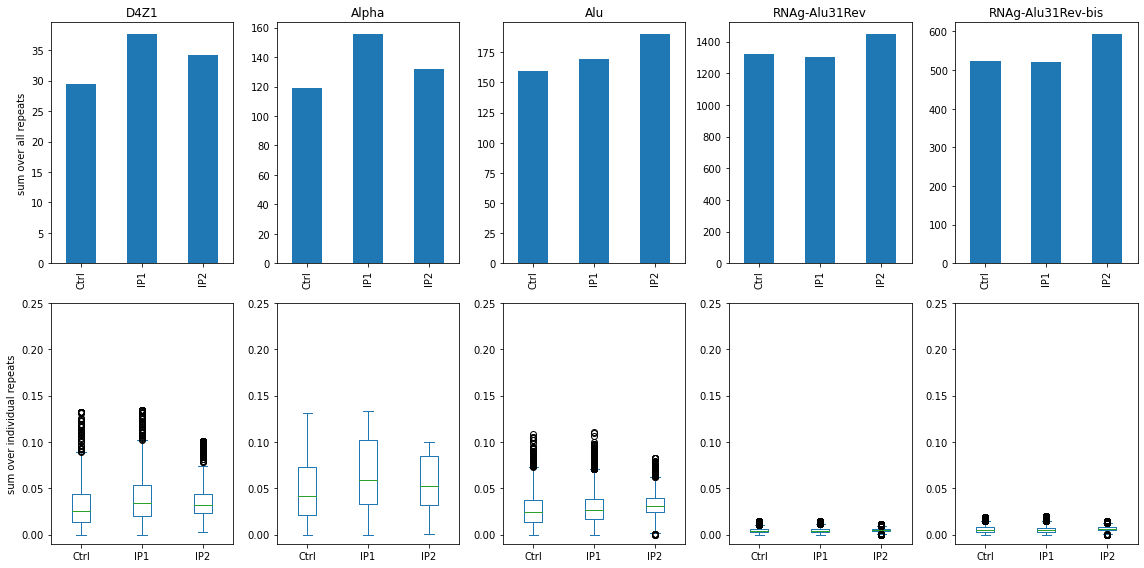

In [51]:
fig, axes = plt.subplots(2, 5, figsize=(16, 8), facecolor="w", layout="tight")
res = {}
for (repeat_element, bedfile), (ax1, ax2) in zip(resbedfiles.items(), axes.T):
    df = pd.read_csv(bedfile, sep="\t", header=None)
    df = (
        df.iloc[:, 3:].rename({3: "Ctrl", 4: "IP1", 5: "IP2"}, axis=1)
        * 1_000_000
        / Total_cov.loc[:, "Clip_q0.99_total_counts"]
    )
    df.sum(axis=0).plot(kind="bar", ax=ax1)
    df.plot(kind="box", ax=ax2)
    ax1.set_title(repeat_element)
    ax2.set_ylim((-0.01, 0.25))
    res_rep = pd.DataFrame(
        {"sum": df.sum(axis=0), "mean": df.mean(axis=0), "std": df.std(axis=0)}
    )
    res[repeat_element] = res_rep
axes[0, 0].set_ylabel("sum over all repeats")
axes[1, 0].set_ylabel("sum over individual repeats")

Text(0, 0.5, 'enrichment over INPUT (%)')

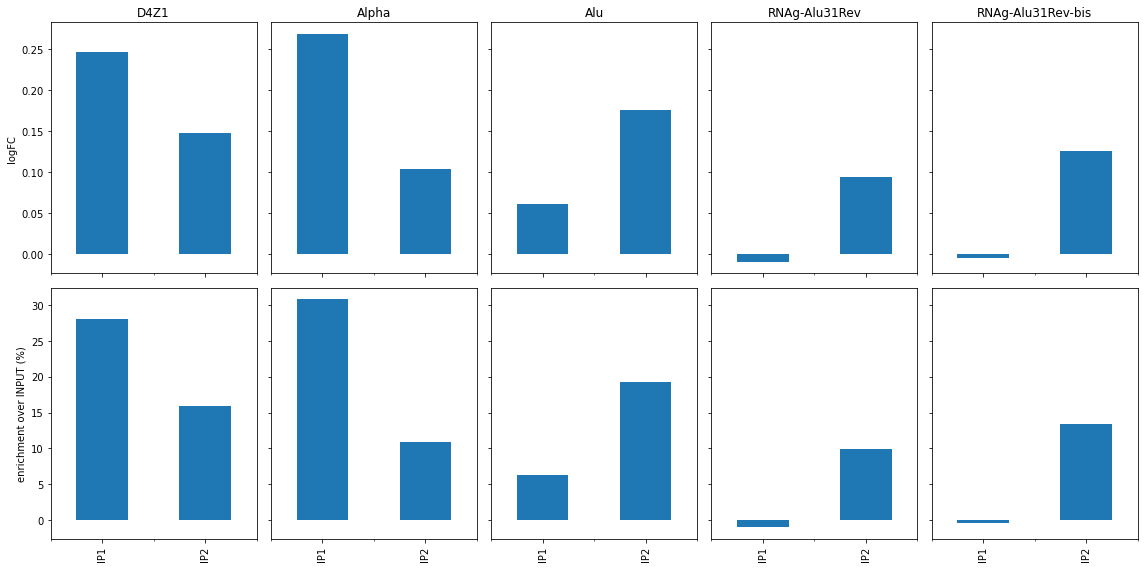

In [52]:
fig, axes = plt.subplots(
    2, 5, figsize=(16, 8), facecolor="w", layout="tight", sharex=True, sharey="row"
)
for (repeat_element, bedfile), (ax1, ax2) in zip(resbedfiles.items(), axes.T):
    df = pd.read_csv(bedfile, sep="\t", header=None)
    df = (
        df.iloc[:, 3:].rename({3: "Ctrl", 4: "IP1", 5: "IP2"}, axis=1)
        * 1_000_000
        / Total_cov.loc[:, "Clip_q0.99_total_counts"]
    )
    sums = df.sum(axis=0)
    logFC = np.log(sums.loc["IP1":] / sums["Ctrl"])
    logFC.plot(kind="bar", ax=ax1)
    perc = 100 * (sums.loc["IP1":] - sums["Ctrl"]) / sums["Ctrl"]
    perc.plot(kind="bar", ax=ax2)
    ax1.set_title(repeat_element)
    # ax2.set_ylim((-0.01, 0.25))
axes[0, 0].set_ylabel("logFC")
axes[1, 0].set_ylabel("enrichment over INPUT (%)")

Get total coverage

In [8]:
bwfiles = {
    "INPUT": "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/D1145C44_trimmed_paired_T2T.bw",
    "IP1": "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/D1145C43_trimmed_paired_T2T.bw",
    "IP2": "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/HN00205099_RawFASTQ_RPE1_WTH3K9me3_paired_T2T.bw",
    # "INPUT_run2": "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/D1145C44_trimmed_run2_paired_T2T.bw",
    # "IP1_run2": "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/D1145C43_trimmed_run2_paired_T2T.bw",
    # "IP2_run2": "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/HN00205099_RawFASTQ_RPE1_WTH3K9me3_run2_paired_T2T.bw",
    # "P3F1": "/home/alex/shared_folder/Ribes-H3K9me3/SRR18183459.bw",
    # "P3F2": "/home/alex/shared_folder/Ribes-H3K9me3/SRR18183460.bw",
    # "P3F3": "/home/alex/shared_folder/Ribes-H3K9me3/SRR18183461.bw",
    # "P7F1": "/home/alex/shared_folder/Ribes-H3K9me3/SRR18183462.bw",
    # "P7F2": "/home/alex/shared_folder/Ribes-H3K9me3/SRR18183463.bw",
    # "P7F3": "/home/alex/shared_folder/Ribes-H3K9me3/SRR18183464.bw",
    # "HFF": "/home/alex/shared_folder/Ribes-H3K9me3/SRR18183465.bw",
}
# for i in range(2):
#     bwfiles[
#         f"split{i}"
#     ] = f"/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/HN00205099_RawFASTQ_RPE1_WTH3K9me3_paired_{i}_T2T.bw"

In [4]:
split0 = utils.load_bw(bwfiles["split0"])
split1 = utils.load_bw(bwfiles["split1"])

In [9]:
def full_counts(signals):
    max_val = 0
    all_vals, all_counts = [], []
    for chr_id, signal in signals.items():
        vals, counts = np.unique(signal, return_counts=True)
        vals = vals.astype(int)
        max_val = max(max_val, vals[-1])
        all_vals.append(vals)
        all_counts.append(counts)
    res = np.zeros(max_val + 1, dtype=int)
    for vals, counts in zip(all_vals, all_counts):
        np.add.at(res, vals, counts)
    return res

In [6]:
full_counts_byfile = {}
full_counts_byfile["split0"] = full_counts(split0)
full_counts_byfile["split1"] = full_counts(split1)

In [45]:
full_counts_byfile["Ctrl"][100:].sum()

164531

Text(0.5, 0.98, 'Histogram of values in signals')

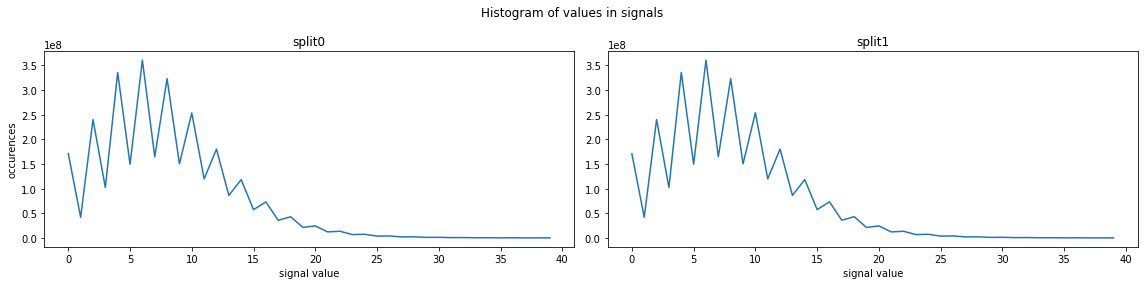

In [7]:
fig, axes = plt.subplots(
    1, len(full_counts_byfile.keys()), figsize=(16, 4), facecolor="w", layout="tight"
)
for (file_id, fcount), ax in zip(full_counts_byfile.items(), axes.flatten()):
    if file_id == "IP2":
        xlim = 400
    else:
        xlim = 40
    ax.plot(fcount[:xlim])
    if file_id == "Ctrl":
        file_id = "INPUT"
    ax.set_title(f"{file_id}")
    ax.set_xlabel("signal value")
axes[0].set_ylabel("occurences")
fig.suptitle("Histogram of values in signals")

In [4]:
# Compute quantiles
q_list = [0.9, 0.95, 0.99, 0.999]
quantiles = {}
for file_id, bwfile in bwfiles.items():
    signals = utils.load_bw(bwfile)
    full = np.concatenate(list(signals.values()))
    quantiles[bwfile] = np.quantile(full, q_list)
pd.DataFrame(quantiles, index=[f"quantile_{q}" for q in q_list]).T.to_csv(
    "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/quantiles_IP2_splits.csv"
)

In [8]:
# Compute pearson correlation after quantile clipping (winsorization)
quantiles = pd.concat(
    [
        pd.read_csv(file, index_col=0)
        for file in [
            "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/quantiles_INPUT_IP1_IP2.csv",
            "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/quantiles_IP2_splits.csv",
        ]
    ]
)
binsize = 1000
corrs = {}
for chr_id in T2T_to_ucsc.keys():
    signals = {}
    for file_id, bwfile in bwfiles.items():
        with pyBigWig.open(bwfile) as bw:
            signals[file_id] = (
                bw.values(chr_id, 0, -1, numpy=True)
                / quantiles.loc[bwfile, "quantile_0.99"]
            )
    corrs[chr_id] = pd.DataFrame(
        np.corrcoef(
            [utils.bin_values(signals[file_id], binsize) for file_id in signals.keys()]
        ),
        index=list(signals.keys()),
        columns=list(signals.keys()),
    )
mindex = pd.MultiIndex.from_product([corrs.keys(), bwfiles.keys()])
df = pd.DataFrame(index=mindex, columns=bwfiles.keys())
for chr_id, subdf in corrs.items():
    df.loc[(chr_id,), :].update(subdf)
filename = utils.safe_filename(
    f"/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/corrs_INPUT_IP1_IP2_2splits_binsize{binsize}_bychrom.csv"
)
df.to_csv(filename)

In [5]:
# Compute Spearman correlation
binsize = 1000
corrs = {}
for chr_id in T2T_to_ucsc.keys():
    print(chr_id)
    rankdata = []
    for file_id, bwfile in bwfiles.items():
        with pyBigWig.open(bwfile) as bw:
            signal = utils.bin_values(bw.values(chr_id, 0, -1, numpy=True), binsize)
        rankdata.append(scipy.stats.rankdata(signal))
        print(f"ranked {file_id}")
    del signal
    corrs[chr_id] = pd.DataFrame(
        np.corrcoef(rankdata),
        index=list(bwfiles.keys()),
        columns=list(bwfiles.keys()),
    )
mindex = pd.MultiIndex.from_product([corrs.keys(), bwfiles.keys()])
df = pd.DataFrame(index=mindex, columns=bwfiles.keys())
for chr_id, subdf in corrs.items():
    df.loc[(chr_id,), :].update(subdf)
filename = utils.safe_filename(
    f"/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/corrs_INPUT_IP1_IP2_2splits_binsize{binsize}_bychrom_spearman.csv"
)
df.to_csv(filename)

NC_060925.1
ranked Ctrl
ranked IP1
ranked IP2
ranked split0
ranked split1
NC_060926.1
ranked Ctrl
ranked IP1
ranked IP2
ranked split0
ranked split1
NC_060927.1
ranked Ctrl
ranked IP1
ranked IP2
ranked split0
ranked split1
NC_060928.1
ranked Ctrl
ranked IP1
ranked IP2
ranked split0
ranked split1
NC_060929.1
ranked Ctrl
ranked IP1
ranked IP2
ranked split0
ranked split1
NC_060930.1
ranked Ctrl
ranked IP1
ranked IP2
ranked split0
ranked split1
NC_060931.1
ranked Ctrl
ranked IP1
ranked IP2
ranked split0
ranked split1
NC_060932.1
ranked Ctrl
ranked IP1
ranked IP2
ranked split0
ranked split1
NC_060933.1
ranked Ctrl
ranked IP1
ranked IP2
ranked split0
ranked split1
NC_060934.1
ranked Ctrl
ranked IP1
ranked IP2
ranked split0
ranked split1
NC_060935.1
ranked Ctrl
ranked IP1
ranked IP2
ranked split0
ranked split1
NC_060936.1
ranked Ctrl
ranked IP1
ranked IP2
ranked split0
ranked split1
NC_060937.1
ranked Ctrl
ranked IP1
ranked IP2
ranked split0
ranked split1
NC_060938.1
ranked Ctrl
ranked IP1
ran

In [23]:
# Testing spearman computation
a = [2, 1, 4, 8, 15, 34, 96, 52]
b = np.arange(8)
c = [2, 4, 8, 4, 2, 4, 8, 4]
data = np.vstack([a, b, c])
print(spearmanr(data, axis=1).correlation)
rankdata = scipy.stats.rankdata(data, axis=1)
print(rankdata)
print(np.corrcoef(rankdata))

[[1.         0.95238095 0.3086067 ]
 [0.95238095 1.         0.3086067 ]
 [0.3086067  0.3086067  1.        ]]
[[2.  1.  3.  4.  5.  6.  8.  7. ]
 [1.  2.  3.  4.  5.  6.  7.  8. ]
 [1.5 4.5 7.5 4.5 1.5 4.5 7.5 4.5]]
[[1.         0.95238095 0.3086067 ]
 [0.95238095 1.         0.3086067 ]
 [0.3086067  0.3086067  1.        ]]


In [7]:
# Retrieve df and corrs
df = pd.read_csv(
    f"/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/corrs_INPUT_IP1_IP2_2splits_binsize{binsize}_bychrom_spearman.csv",
    index_col=[0, 1],
)
corrs = {}
for chr_id in df.index.levels[0]:
    corrs[chr_id] = df.loc[(chr_id,), :]
df

Ctrl       IP1       IP2    split0    split1
NC_060925.1 Ctrl    1.000000  0.120750  0.125478  0.090867  0.090595
            IP1     0.120750  1.000000  0.238562  0.163486  0.163271
            IP2     0.125478  0.238562  1.000000  0.619591  0.619465
            split0  0.090867  0.163486  0.619591  1.000000  0.332185
            split1  0.090595  0.163271  0.619465  0.332185  1.000000
...                      ...       ...       ...       ...       ...
NC_060948.1 Ctrl    1.000000  0.633983  0.609590  0.628548  0.624821
            IP1     0.633983  1.000000  0.666250  0.668763  0.666400
            IP2     0.609590  0.666250  1.000000  0.731374  0.727993
            split0  0.628548  0.668763  0.731374  1.000000  0.694488
            split1  0.624821  0.666400  0.727993  0.694488  1.000000

[120 rows x 5 columns]

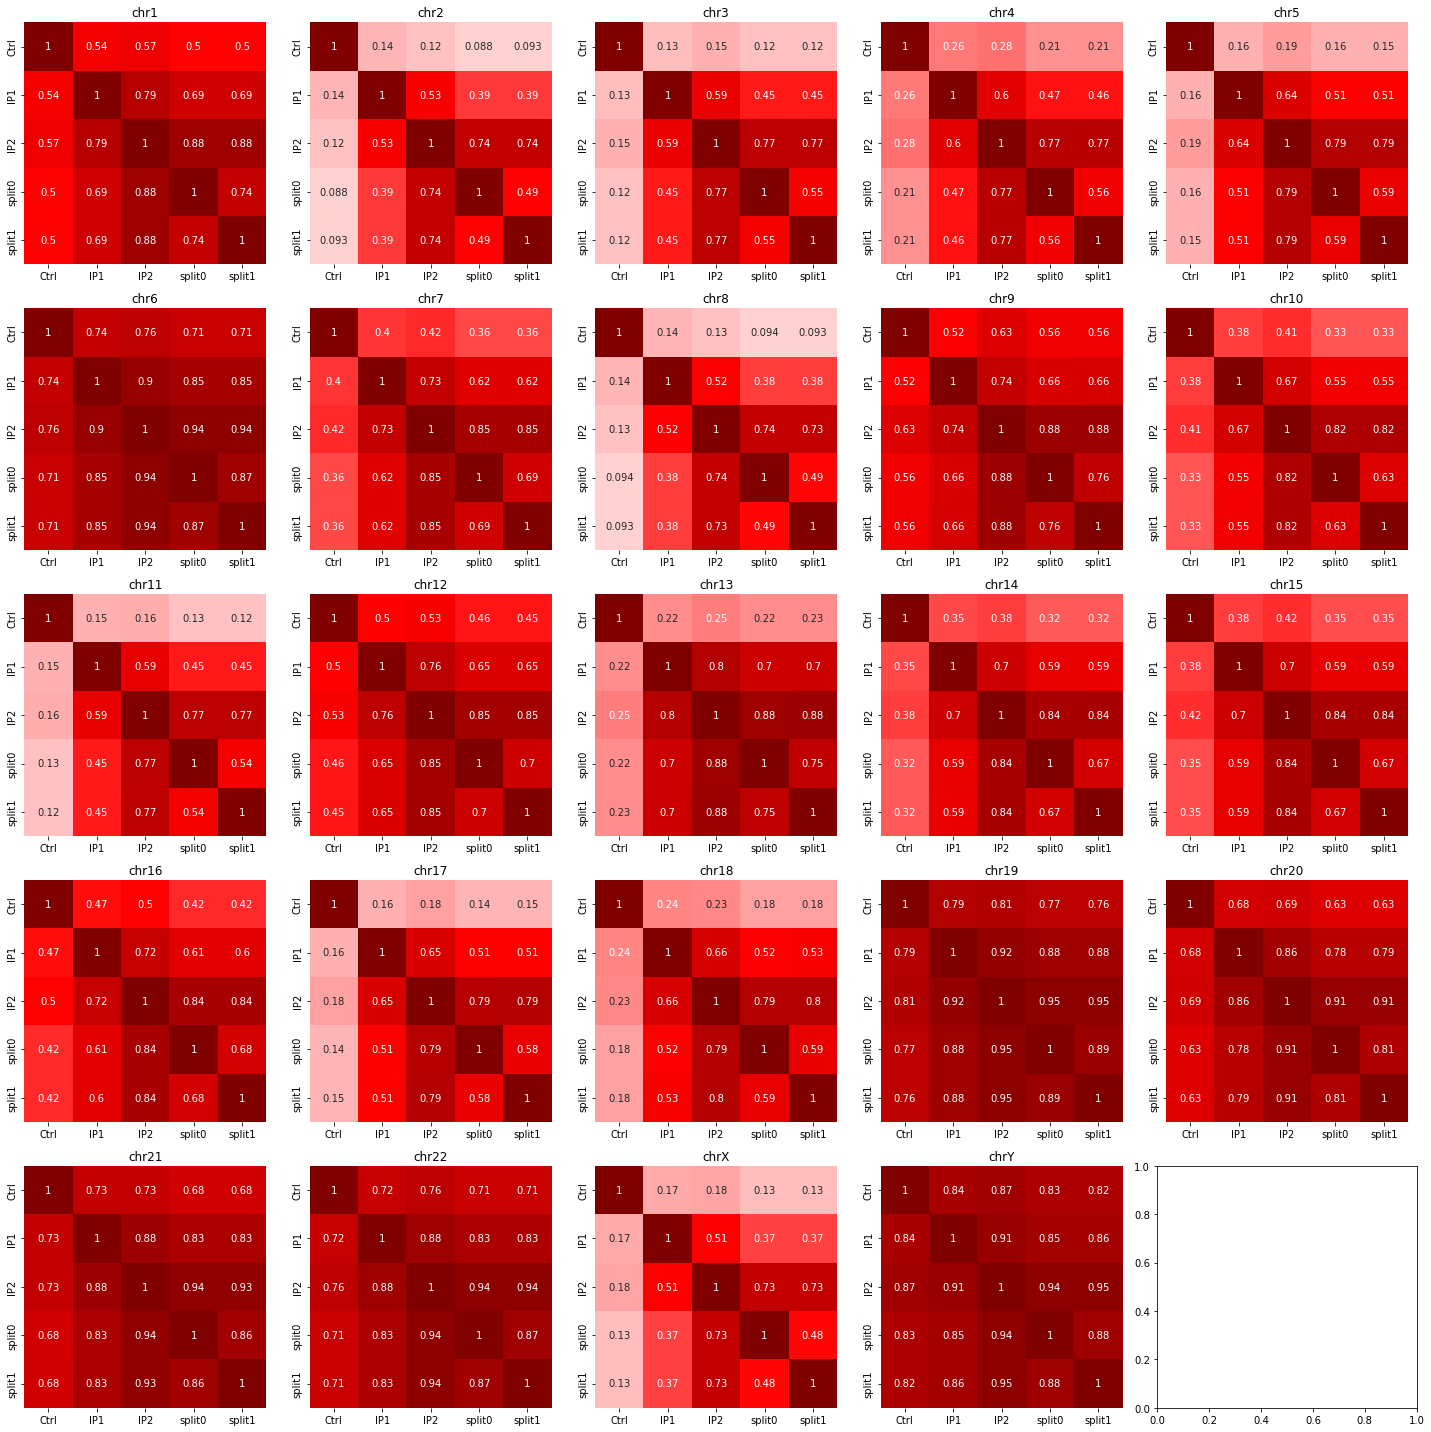

In [9]:
fig, axes = plt.subplots(5, 5, figsize=(20, 20), facecolor="w", layout="tight")
for (k, v), ax in zip(corrs.items(), axes.flatten()):
    sns.heatmap(v, center=0, cmap="seismic", cbar=False, ax=ax, annot=True, square=True)
    ax.set_title(T2T_to_ucsc[k])
filename = utils.safe_filename(
    f"/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/corrplot_INPUT_IP1_IP2_2splits_binsize{binsize}_bychrom_clipnorm0.99.png"
)
fig.savefig(filename)

In [5]:
dfs = {}
for binsize in 10 ** np.arange(8):
    dfs[binsize] = pd.read_csv(
        f"/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/corrs_INPUT_IP1_IP2_binsize{binsize}_bychrom_clipnorm0.99.csv",
        index_col=0,
    ).unstack()
all_corrs = pd.DataFrame(dfs)

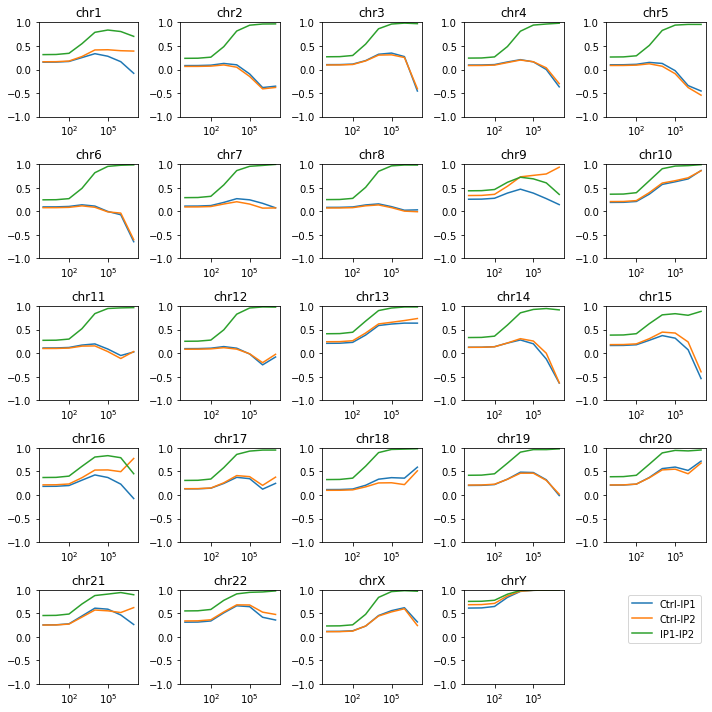

In [6]:
fig, axes = plt.subplots(5, 5, figsize=(10, 10), facecolor="w", layout="tight")
for chr_id, ax in zip(all_corrs.index.levels[0], axes.flatten()):
    all_corrs.loc[(chr_id,), :].T.plot(ax=ax, legend=False)
    ax.set_xscale("log")
    ax.set_title(T2T_to_ucsc[chr_id])
    ax.set_ylim(-1, 1)
axes[-1, -1].legend(*axes[0, 0].get_legend_handles_labels())
axes[-1, -1].set_axis_off()

In [3]:
with pyBigWig.open(
    "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/HN00205099_RawFASTQ_RPE1_WTH3K9me3_paired_T2T.bw"
) as bw:
    arr = bw.values("NC_060925.1", 0, -1, numpy=True)
    arr /= np.sum(arr)
with pyBigWig.open(
    "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/D1145C44_trimmed_paired_T2T.bw"
) as bw:
    arr_ctrl = bw.values("NC_060925.1", 0, -1, numpy=True)
    arr_ctrl /= np.sum(arr_ctrl)

/tmp/ipykernel_3622705/2827441187.py:2: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(np.where(arr_ctrl != 0, np.log(arr / arr_ctrl), 0))
/tmp/ipykernel_3622705/2827441187.py:2: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(np.where(arr_ctrl != 0, np.log(arr / arr_ctrl), 0))
/tmp/ipykernel_3622705/2827441187.py:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.where(arr_ctrl != 0, np.log(arr / arr_ctrl), 0))


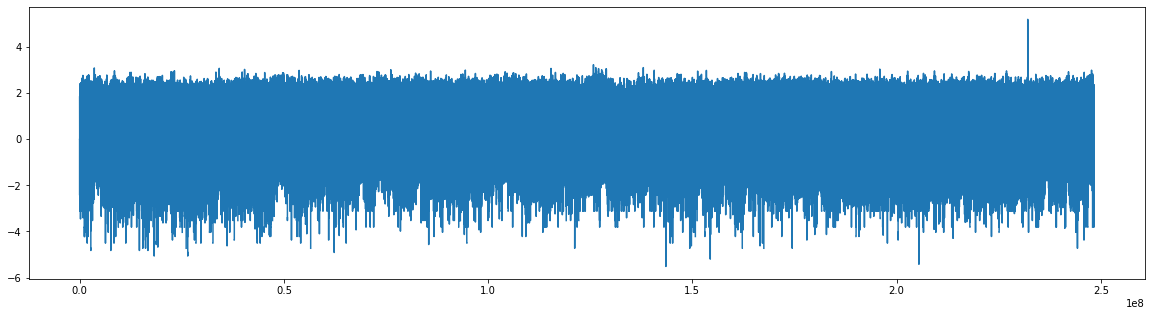

In [4]:
plt.figure(figsize=(20, 5))
plt.plot(np.where(arr_ctrl != 0, np.log(arr / arr_ctrl), 0))

/tmp/ipykernel_3622705/2506666542.py:2: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(np.where(arr_ctrl != 0, np.log(arr / arr_ctrl), 0)[:int(1e7)])
/tmp/ipykernel_3622705/2506666542.py:2: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(np.where(arr_ctrl != 0, np.log(arr / arr_ctrl), 0)[:int(1e7)])
/tmp/ipykernel_3622705/2506666542.py:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.where(arr_ctrl != 0, np.log(arr / arr_ctrl), 0)[:int(1e7)])


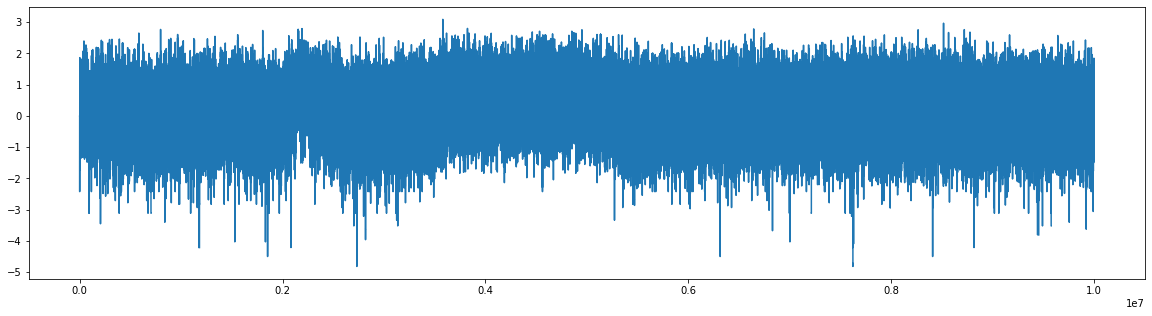

In [5]:
plt.figure(figsize=(20, 5))
plt.plot(np.where(arr_ctrl != 0, np.log(arr / arr_ctrl), 0)[: int(1e7)])

In [6]:
arr_bin = utils.bin_values(arr, 1000)
arr_ctrl_bin = utils.bin_values(arr_ctrl, 1000)

/tmp/ipykernel_3622705/3851441246.py:2: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(np.arange(0, len(arr), 1000)[:int(1e4)], np.where(arr_ctrl_bin != 0, np.log(arr_bin / arr_ctrl_bin), 0)[:int(1e4)])
/tmp/ipykernel_3622705/3851441246.py:2: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(np.arange(0, len(arr), 1000)[:int(1e4)], np.where(arr_ctrl_bin != 0, np.log(arr_bin / arr_ctrl_bin), 0)[:int(1e4)])
/tmp/ipykernel_3622705/3851441246.py:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.arange(0, len(arr), 1000)[:int(1e4)], np.where(arr_ctrl_bin != 0, np.log(arr_bin / arr_ctrl_bin), 0)[:int(1e4)])


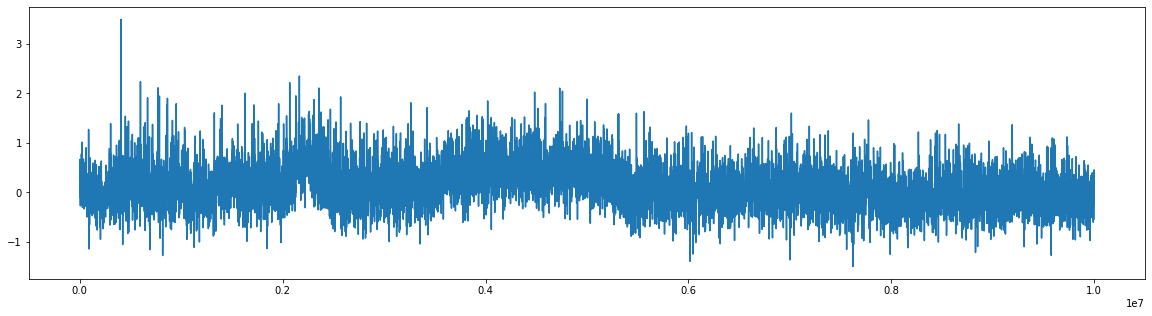

In [9]:
plt.figure(figsize=(20, 5))
plt.plot(
    np.arange(0, len(arr), 1000)[: int(1e4)],
    np.where(arr_ctrl_bin != 0, np.log(arr_bin / arr_ctrl_bin), 0)[: int(1e4)],
)

In [ ]:
clipnorm_signals = {k: utils.clipnorm(utils.load_bw(v)) for k, v in bwfiles.items()}

In [25]:
sums = {
    file_id: sum(np.sum(v) for v in signal.values())
    for file_id, signal in clipnorm_signals.items()
}
sums

KeyboardInterrupt: 

In [26]:
binsize = 1000
input_binned = np.concatenate(
    [
        utils.bin_values(clipnorm_signals["Ctrl"][chr_id] / sums["Ctrl"], binsize)
        for chr_id in clipnorm_signals["Ctrl"].keys()
    ]
)
ip1_binned = np.concatenate(
    [
        utils.bin_values(clipnorm_signals["IP1"][chr_id] / sums["IP1"], binsize)
        for chr_id in clipnorm_signals["IP1"].keys()
    ]
)
ip2_binned = np.concatenate(
    [
        utils.bin_values(clipnorm_signals["IP2"][chr_id] / sums["IP2"], binsize)
        for chr_id in clipnorm_signals["IP1"].keys()
    ]
)

/tmp/ipykernel_3469336/3213355807.py:2: RuntimeWarning: divide by zero encountered in true_divide
  ax.scatter((ip1_binned + input_binned)/2, np.log(ip1_binned / input_binned)/np.log(2))
/tmp/ipykernel_3469336/3213355807.py:2: RuntimeWarning: invalid value encountered in true_divide
  ax.scatter((ip1_binned + input_binned)/2, np.log(ip1_binned / input_binned)/np.log(2))
/tmp/ipykernel_3469336/3213355807.py:2: RuntimeWarning: divide by zero encountered in log
  ax.scatter((ip1_binned + input_binned)/2, np.log(ip1_binned / input_binned)/np.log(2))


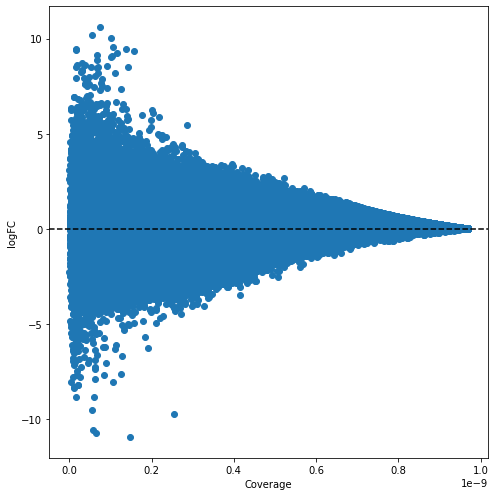

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7), facecolor="w", layout="tight")
ax.scatter(
    (ip1_binned + input_binned) / 2, np.log(ip1_binned / input_binned) / np.log(2)
)
ax.set_xlabel("Coverage")
ax.set_ylabel("logFC")
ax.axhline(y=0, color="k", linestyle="--")

/tmp/ipykernel_3469336/1035589921.py:2: RuntimeWarning: divide by zero encountered in true_divide
  ax.scatter((ip2_binned + input_binned)/2, np.log(ip2_binned / input_binned))
/tmp/ipykernel_3469336/1035589921.py:2: RuntimeWarning: invalid value encountered in true_divide
  ax.scatter((ip2_binned + input_binned)/2, np.log(ip2_binned / input_binned))
/tmp/ipykernel_3469336/1035589921.py:2: RuntimeWarning: divide by zero encountered in log
  ax.scatter((ip2_binned + input_binned)/2, np.log(ip2_binned / input_binned))


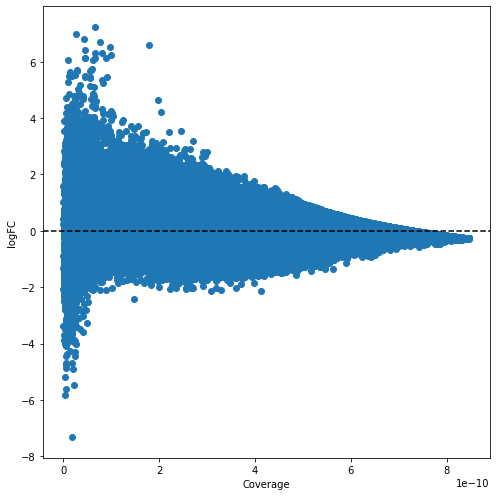

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7), facecolor="w", layout="tight")
ax.scatter((ip2_binned + input_binned) / 2, np.log(ip2_binned / input_binned))
ax.set_xlabel("Coverage")
ax.set_ylabel("logFC")
ax.axhline(y=0, color="k", linestyle="--")

In [22]:
bins = np.arange(-0.5, len(ip1_binned) + 10000, 10000)

array([-5.00000000e-01,  9.99500000e+02,  1.99950000e+03, ...,
        3.11709995e+07,  3.11719995e+07,  3.11729995e+07])

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7), facecolor="w", layout="tight")
ax.hist2d(
    x=ip1_binned, y=ip2_binned, bins=bins, cmap="YlOrRd", norm=mpl.colors.LogNorm()
)
ax.set_xlabel("IP1")
ax.set_ylabel("IP2")
# ax.legend(loc='lower right')

: 

In [8]:
# with open('/home/alex/shared_folder/Human/T2T-CHM13v2.0_NCBI2UCSC.txt', 'w') as f:
#     for ucsc, ncbi in T2T_chr_ids.items():
#         f.write(f'{ncbi}\tchr{ucsc}\n')

Name of chromosomes in GRCh38 and T2T-CHM13v2.0
Header for BigWig files, with chromosome lengths

In [3]:
hg38_chr_ids = {
    1: "NC_000001.11",
    2: "NC_000002.12",
    3: "NC_000003.12",
    4: "NC_000004.12",
    5: "NC_000005.10",
    6: "NC_000006.12",
    7: "NC_000007.14",
    8: "NC_000008.11",
    9: "NC_000009.12",
    10: "NC_000010.11",
    11: "NC_000011.10",
    12: "NC_000012.12",
    13: "NC_000013.11",
    14: "NC_000014.9",
    15: "NC_000015.10",
    16: "NC_000016.10",
    17: "NC_000017.11",
    18: "NC_000018.10",
    19: "NC_000019.10",
    20: "NC_000020.11",
    21: "NC_000021.9",
    22: "NC_000022.11",
    "X": "NC_000023.11",
    "Y": "NC_000024.10",
}
T2T_chr_ids = {
    1: "NC_060925.1",
    2: "NC_060926.1",
    3: "NC_060927.1",
    4: "NC_060928.1",
    5: "NC_060929.1",
    6: "NC_060930.1",
    7: "NC_060931.1",
    8: "NC_060932.1",
    9: "NC_060933.1",
    10: "NC_060934.1",
    11: "NC_060935.1",
    12: "NC_060936.1",
    13: "NC_060937.1",
    14: "NC_060938.1",
    15: "NC_060939.1",
    16: "NC_060940.1",
    17: "NC_060941.1",
    18: "NC_060942.1",
    19: "NC_060943.1",
    20: "NC_060944.1",
    21: "NC_060945.1",
    22: "NC_060946.1",
    "X": "NC_060947.1",
    "Y": "NC_060948.1",
}
sacCer3_chr_ids = {
    1: "I",
    2: "II",
    3: "III",
    4: "IV",
    5: "V",
    6: "VI",
    7: "VII",
    8: "VIII",
    9: "IX",
    10: "X",
    11: "XI",
    12: "XII",
    13: "XIII",
    14: "XIV",
    15: "XV",
    16: "XVI",
}
T2T_chr_ids_rev = {
    "NC_060925.1": "1",
    "NC_060926.1": "2",
    "NC_060927.1": "3",
    "NC_060928.1": "4",
    "NC_060929.1": "5",
    "NC_060930.1": "6",
    "NC_060931.1": "7",
    "NC_060932.1": "8",
    "NC_060933.1": "9",
    "NC_060934.1": "10",
    "NC_060935.1": "11",
    "NC_060936.1": "12",
    "NC_060937.1": "13",
    "NC_060938.1": "14",
    "NC_060939.1": "15",
    "NC_060940.1": "16",
    "NC_060941.1": "17",
    "NC_060942.1": "18",
    "NC_060943.1": "19",
    "NC_060944.1": "20",
    "NC_060945.1": "21",
    "NC_060946.1": "22",
    "NC_060947.1": "X",
    "NC_060948.1": "Y",
}

In [8]:
# ip_H3K9me3 = utils.load_bw('/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/macs_output/D1145C43_trimmed_paired_T2T_treat_pileup.bw')
with pyBigWig.open(
    "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/macs_output/D1145C43_trimmed_paired_T2T_treat_pileup.bw"
) as bw:
    ip_H3K9me3 = {}
    for k, length in bw.chroms().items():
        ip_H3K9me3[k] = bw.stats(
            k, 0, length - (length % 1000), numpy=True, nBins=length // 1000
        )

In [4]:
with pyBigWig.open(
    "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/macs_output/D1145C43_trimmed_paired_T2T_treat_pileup.bw"
) as bw:
    chr1 = bw.values("NC_060925.1", 120_000_000, 150_000_000, numpy=True)

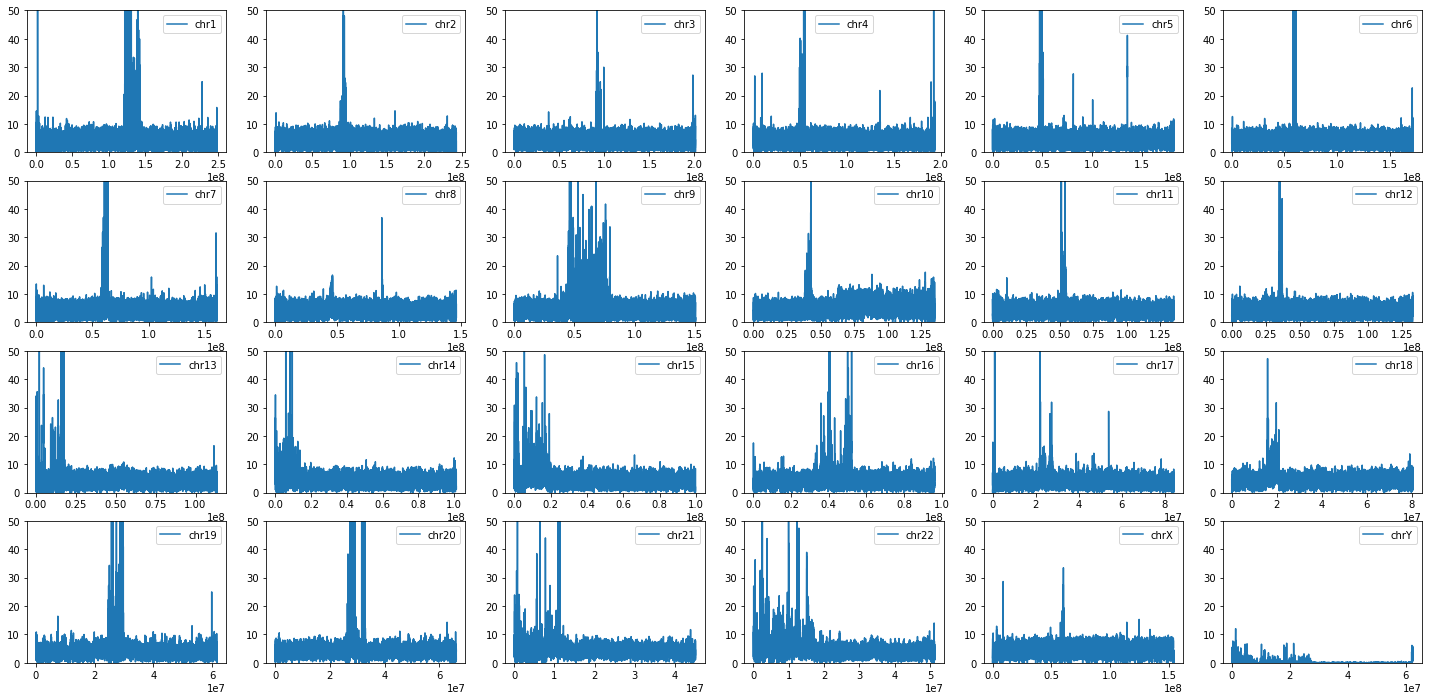

In [19]:
fig, axes = plt.subplots(4, 6, figsize=(25, 12), facecolor="w")
for ax, (chr_id, signal) in zip(axes.flatten(), ip_H3K9me3.items()):
    ax.plot(
        np.arange(0, len(signal) * 1000, 1000),
        signal,
        label=f"chr{T2T_chr_ids_rev[chr_id]}",
    )
    # ax.set_ylim((0, 50))
    ax.legend()

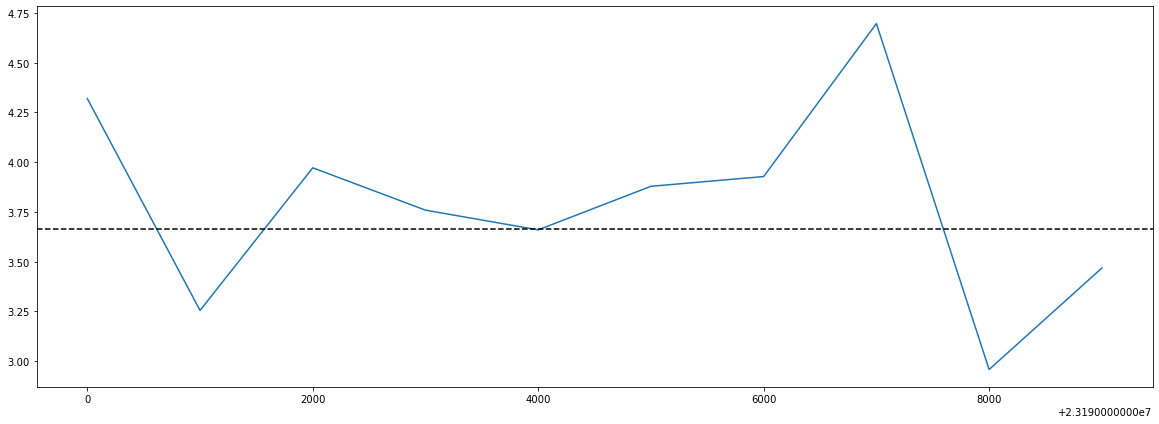

In [38]:
chr_id = "NC_060926.1"
start = 23_190_000
stop = 23_200_000
signal = ip_H3K9me3[chr_id]
fig, ax = plt.subplots(1, 1, figsize=(20, 7), facecolor="w")
ax.plot(
    np.arange(start, stop, 1000),
    signal[start // 1000 : stop // 1000],
    label=f"chr{T2T_chr_ids_rev[chr_id]}",
)
ax.axhline(y=np.mean(signal), color="k", linestyle="--")

In [5]:
# peaks = [[121639796, 121641499],
#          [121652802, 121654851],
#          [121658251, 121659261],
#          [121667490, 121668342],
#          [121669919, 121670422],
#          [121672266, 121674256],
#          [121676143, 121676926],
#          [121681998, 121682277],
#          [121686213, 121687044],
#          [121688713, 121689831],
#          [121697892, 121699377]]
peaks = []

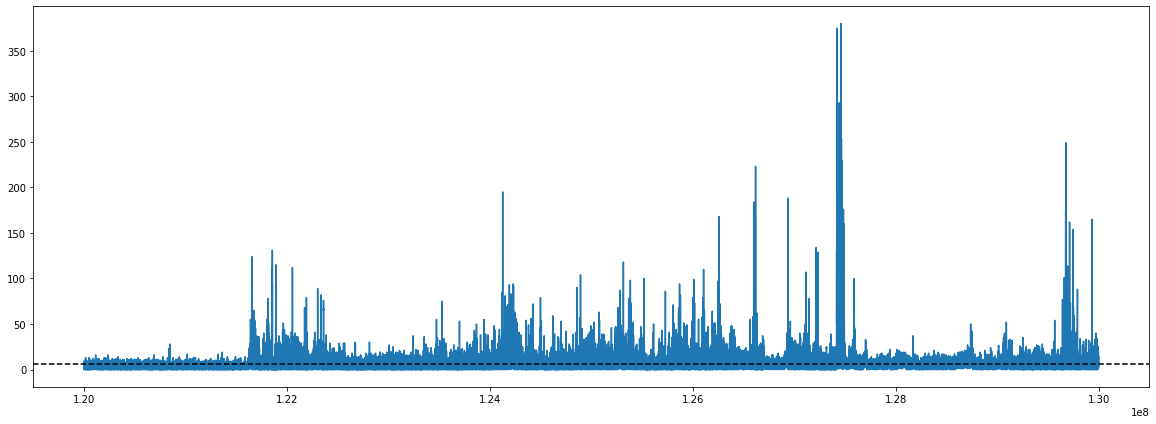

In [8]:
offset = 120_000_000
start = 120_000_000
stop = 130_000_000
fig, ax = plt.subplots(1, 1, figsize=(20, 7), facecolor="w")
ax.plot(np.arange(start, stop), chr1[start - offset : stop - offset], label="chr1")
ax.axhline(y=np.mean(chr1), color="k", linestyle="--")
for peak_start, peak_stop in peaks:
    ax.plot([peak_start, peak_stop], [15, 15], color="r", marker=".", linewidth=1)

Parse bam files and save in npz format

In [ ]:
data = "Judith-H3K9me3"
genome = "T2T-CHM13v2.0"
ip_coord = utils.parse_bam(
    Path(
        data_dir,
        data,
        "results",
        "alignments",
        genome,
        "HN00205099_RawFASTQ_RPE1_WTH3K9me3_paired.sorted.bam",
    )
)
# ctrl_coord = utils.parse_bam(
#     Path(
#         data_dir,
#         data,
#         "results",
#         "alignments",
#         genome,
#         "D1145C44_trimmed_paired_T2T_over_0.55_with_model_inception3.1.sorted.bam",
#     )
# )
ip_npz_file = Path(
    data_dir,
    data,
    "results",
    "alignments",
    genome,
    f"{data}_{genome}_IP2_coord_all_chr.npz",
)
# ctrl_npz_file = Path(
#     data_dir,
#     data,
#     "results",
#     "alignments",
#     genome,
#     f"{data}_{genome}_Control_over_0.55_with_model_inception3.1_coord_all_chr.npz",
# )
if not ip_npz_file.is_file():
    np.savez_compressed(ip_npz_file, **ip_coord)
    print(f"saved {ip_npz_file}")
# if not ctrl_npz_file.is_file():
#     np.savez_compressed(ctrl_npz_file, **ctrl_coord)
#     print(f"saved {ctrl_npz_file}")

In [5]:
with open(
    "/home/alex/shared_folder/Human/genome/T2T-CHM13v2.0/T2T-CHM13v2.0_chrom_sizes.json"
) as f:
    chr_lens = json.load(f)
chr_lens

{'NC_060925.1': 248387328,
 'NC_060926.1': 242696752,
 'NC_060927.1': 201105948,
 'NC_060928.1': 193574945,
 'NC_060929.1': 182045439,
 'NC_060930.1': 172126628,
 'NC_060931.1': 160567428,
 'NC_060932.1': 146259331,
 'NC_060933.1': 150617247,
 'NC_060934.1': 134758134,
 'NC_060935.1': 135127769,
 'NC_060936.1': 133324548,
 'NC_060937.1': 113566686,
 'NC_060938.1': 101161492,
 'NC_060939.1': 99753195,
 'NC_060940.1': 96330374,
 'NC_060941.1': 84276897,
 'NC_060942.1': 80542538,
 'NC_060943.1': 61707364,
 'NC_060944.1': 66210255,
 'NC_060945.1': 45090682,
 'NC_060946.1': 51324926,
 'NC_060947.1': 154259566,
 'NC_060948.1': 62460029}

In [44]:
mids = utils.load_bw(
    "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/HN00205099_RawFASTQ_RPE1_WTH3K9me3_paired_mid_points.bw"
)

['NC_060925.1',
 'NC_060926.1',
 'NC_060927.1',
 'NC_060928.1',
 'NC_060929.1',
 'NC_060930.1',
 'NC_060931.1',
 'NC_060932.1',
 'NC_060933.1',
 'NC_060934.1',
 'NC_060935.1',
 'NC_060936.1',
 'NC_060937.1',
 'NC_060938.1',
 'NC_060939.1',
 'NC_060940.1',
 'NC_060941.1',
 'NC_060942.1',
 'NC_060943.1',
 'NC_060944.1',
 'NC_060945.1',
 'NC_060946.1',
 'NC_060947.1',
 'NC_060948.1']

Parse single-end bam files and save in npz format

In [15]:
data = "RNAPII_quiescence"
genome = "sacCer3"
ip_coord = utils.parse_bam(
    Path(
        data_dir,
        data,
        "results",
        "alignments",
        genome,
        f"WT_expo_IP_1_below_0.2_with_model_inception_expo_2_1.0.sorted.bam",
    ),
    paired=False,
    fragment_length=0,
)
ctrl_coord = utils.parse_bam(
    Path(
        data_dir,
        data,
        "results",
        "alignments",
        genome,
        f"untagged_expo_IP_1_below_0.2_with_model_inception_expo_2_1.0.sorted.bam",
    ),
    paired=False,
    fragment_length=0,
)
ip_npz_file = Path(
    data_dir,
    data,
    "results",
    "alignments",
    genome,
    f"WT_expo_IP_1_below_0.2_with_model_inception_expo_2_1.0_coord_all_chr.npz",
)
ctrl_npz_file = Path(
    data_dir,
    data,
    "results",
    "alignments",
    genome,
    f"untagged_expo_IP_1_below_0.2_with_model_inception_expo_2_1.0_coord_all_chr.npz",
)
if not ip_npz_file.is_file():
    np.savez_compressed(ip_npz_file, **ip_coord)
    print(f"saved {ip_npz_file}")
if not ctrl_npz_file.is_file():
    np.savez_compressed(ctrl_npz_file, **ctrl_coord)
    print(f"saved {ctrl_npz_file}")
# for i in range(30, 38):
#     ip_access = f'SRR146783{i+8}'
#     ctrl_access = f'SRR146783{i}'
#     ip_coord = utils.parse_bam(Path(data_dir, data, 'results', 'alignments', genome, f'{ip_access}_T2T.sorted.bam'), paired=False, fragment_length=250)
#     ctrl_coord = utils.parse_bam(Path(data_dir, data, 'results', 'alignments', genome, f'{ctrl_access}_T2T.sorted.bam'), paired=False, fragment_length=250)
#     ip_npz_file = Path(data_dir, data, 'results', 'alignments', genome, f'{data}_{ip_access}_{genome}_IP_coord_all_chr.npz')
#     ctrl_npz_file = Path(data_dir, data, 'results', 'alignments', genome, f'{data}_{ctrl_access}_{genome}_Control_coord_all_chr.npz')
#     if not ip_npz_file.is_file():
#         np.savez_compressed(ip_npz_file, **ip_coord)
#     if not ctrl_npz_file.is_file():
#         np.savez_compressed(ctrl_npz_file, **ctrl_coord)

0/8187 reads rejected
0/77829 reads rejected


Check mapping qualities

In [71]:
data = "Judith-H3K9me3"  # "RNAPII_quiescence"  #
genome = "T2T-CHM13v2.0"  # "sacCer3"  #
# mapqs_IP1_Manuela = utils.inspect_bam_mapq(Path(data_dir, data, 'bam_cer_only', f'untagged_expo_IP_1.cer.3MM.bam'))
# mapqs_IP1 = utils.inspect_bam_mapq(Path(data_dir, data, 'results', 'alignments', genome, f'untagged_expo_IP_1.sorted.bam'))
mapqs = utils.inspect_bam_mapq(
    Path(
        data_dir,
        data,
        "results",
        "alignments",
        genome,
        f"HN00205099_RawFASTQ_RPE1_WTH3K9me3_paired.sorted.bam",
    )
)

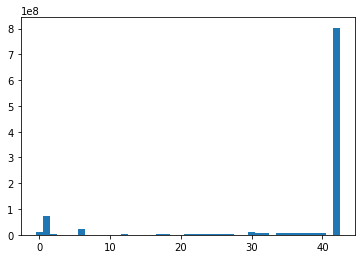

In [72]:
plt.bar(mapqs.keys(), mapqs.values(), 1)
plt.show()
plt.close()

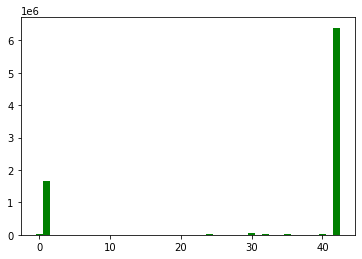

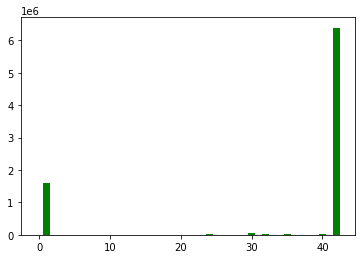

In [21]:
plt.bar(mapqs_IP1.keys(), mapqs_IP1.values(), 1)
plt.show()
plt.close()
plt.bar(mapqs_IP1_Manuela.keys(), mapqs_IP1_Manuela.values(), 1)
plt.show()
plt.close()

Plot fragment lengths

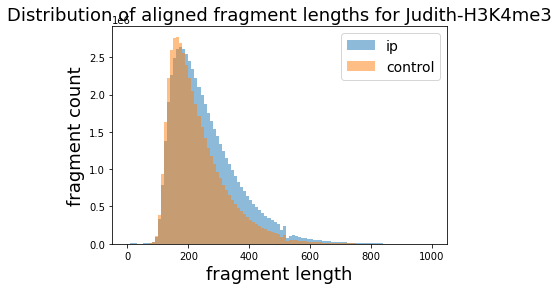

In [6]:
data = "Judith-H3K4me3"
genome = "T2T-CHM13v2.0"
with np.load(
    Path(
        data_dir,
        data,
        "results",
        "alignments",
        genome,
        f"{data}_{genome}_IP_coord_all_chr.npz",
    )
) as f:
    ip_lengths = []
    for key in f.keys():
        ip_lengths.append(np.diff(f[key], axis=1).ravel())
    ip_lengths = np.concatenate(ip_lengths)
with np.load(
    Path(
        data_dir,
        data,
        "results",
        "alignments",
        genome,
        f"{data}_{genome}_Control_coord_all_chr.npz",
    )
) as f:
    ctrl_lengths = []
    for key in f.keys():
        ctrl_lengths.append(np.diff(f[key], axis=1).ravel())
    ctrl_lengths = np.concatenate(ctrl_lengths)
plt.hist(ip_lengths, bins=100, range=(0, 1000), label="ip", alpha=0.5)
plt.hist(ctrl_lengths, bins=100, range=(0, 1000), label="control", alpha=0.5)
plt.legend(fontsize=14)
plt.title(f"Distribution of aligned fragment lengths for {data}", fontsize=18)
plt.xlabel("fragment length", fontsize=18)
plt.ylabel("fragment count", fontsize=18)
fig_name = Path(
    data_dir,
    data,
    "results",
    "alignments",
    genome,
    f"{data}_fragment_length_distribution.png",
)
fig_name = utils.safe_filename(fig_name)
plt.savefig(fig_name, bbox_inches="tight")
plt.show()
plt.close()

Roman numeral chromosome conversions in npz

In [ ]:
data = "RNAPII_quiescence"
genome = "sacCer3"
#### Convert to roman
# chr_coords = {}
# with np.load(Path(data_dir, data, 'results', 'alignments', genome, 'untagged_expo_IP_1.cer.3MM_coord_all_chr.npz')) as f:
#     for key in f.keys():
#         try:
#             chr_coords[f'chr{utils.int_to_roman(int(key[3:]))}'] = f[key]
#         except KeyError:
#             print(f'{key} is unused')
# np.savez_compressed(Path(data_dir, data, 'results', 'alignments', genome, 'untagged_expo_IP_1.cer.3MM_roman_coord_all_chr.npz'),
#                     **chr_coords)

#### Convert to int
chr_coords = {}
with np.load(
    Path(
        data_dir,
        data,
        "results",
        "alignments",
        genome,
        "untagged_expo_IP_1_coord_all_chr.npz",
    )
) as f:
    for key in f.keys():
        if key == "chrM":
            print(f"{key} is unused")
            continue
        try:
            chr_coords[f"chr{utils.roman_to_int(key[3:]):02}"] = f[key]
        except KeyError:
            print(f"{key} is unused")
# np.savez_compressed(Path(data_dir, data, 'results', 'alignments', genome, 'untagged_expo_IP_1_arabic_coord_all_chr.npz'),
#                     **chr_coords)

In [7]:
data = "RNAPII_quiescence"
genome = "sacCer3"
with np.load(
    Path(
        data_dir,
        data,
        "results",
        "alignments",
        genome,
        "untagged_expo_IP_1.cer.3MM_coord_all_chr.npz",
    )
) as f:
    for key in f.keys():
        print(key)

chr01
chr02
chr03
chr04
chr05
chr06
chr07
chr08
chr09
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chrmt
2-micron


Custom alignment analysis with specified binsize

In [9]:
data = "Judith-H3K9me3"
genome = "T2T-CHM13v2.0"
basename = "IP2_"  #'over_0.55_with_model_inception3.1_'
ip_coord_file = "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/HN00205099_RawFASTQ_RPE1_WTH3K9me3_paired_mid_points.bw"
# f'/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/{data}_{genome}_IP_{basename}coord_all_chr.npz'
ctrl_coord_file = "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/D1145C44_trimmed_paired_T2T_mid_points.bw"
# f'/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/{data}_{genome}_Control_{basename}coord_all_chr.npz'
chr_sizes_file = Path(data_dir, "Human", "genome", genome, f"{genome}_chrom_sizes.json")
max_frag_len = 500
binsize = 10_000_000_000

out_file = Path(
    data_dir,
    data,
    "results",
    "alignments",
    genome,
    f"{data}_{genome}_{basename}maxfraglen_{max_frag_len}_binsize_{binsize}.csv",
)
utils.genome_enrichment(
    ip_coord_file,
    ctrl_coord_file,
    chr_sizes_file,
    out_file,
    binsize,
    max_frag_len=max_frag_len,
    from_bw=True,
)

In [25]:
data = "RNAPII_quiescence"
genome = "sacCer3"
chr_sizes_file = Path(
    data_dir, "SCerevisiae", "genome", genome, f"{genome}_chrom_sizes_roman.json"
)
max_frag_len = 500
binsize = 200

ip_prefix = "WT_expo_IP_1_below_0.2_with_model_inception_expo_2_1.0"
ctrl_prefix = "untagged_expo_IP_1_below_0.2_with_model_inception_expo_2_1.0"
basename = f"{ip_prefix}_vs_{ctrl_prefix}_"
ip_coord_file = Path(
    data_dir, data, "results", "alignments", genome, f"{ip_prefix}_coord_all_chr.npz"
)
ctrl_coord_file = Path(
    data_dir, data, "results", "alignments", genome, f"{ctrl_prefix}_coord_all_chr.npz"
)
out_file = Path(
    data_dir,
    data,
    "results",
    "alignments",
    genome,
    f"{data}_{genome}_{basename}maxfraglen_{max_frag_len}_binsize_{binsize}.csv",
)
utils.genome_enrichment(
    ip_coord_file,
    ctrl_coord_file,
    chr_sizes_file,
    out_file,
    binsize,
    max_frag_len=max_frag_len,
)
# for i in range(30, 38):
#     ip_access = f'SRR146783{i+8}'
#     ctrl_access = f'SRR146783{i}'
#     ip_coord_file = Path(data_dir, data, 'results', 'alignments', genome, f'{data}_{ip_access}_{genome}_IP_coord_all_chr.npz')
#     ctrl_coord_file = Path(data_dir, data, 'results', 'alignments', genome, f'{data}_{ctrl_access}_{genome}_Control_coord_all_chr.npz')
#     out_file = Path(data_dir, data, 'results', 'alignments', genome, f'{data}_{ip_access}_{genome}_maxfraglen_{max_frag_len}_binsize_{binsize}.csv')
#     utils.genome_enrichment(ip_coord_file, ctrl_coord_file, chr_sizes_file, out_file, max_frag_len, binsize)

Load alignment results

In [111]:
data = "Judith-H3K9me3"  # 'RNAPII_quiescence' #
genome = "T2T-CHM13v2.0"  # 'sacCer3' #
max_frag_len = 500
binsize = 1000
# ip_prefix = "WT_expo_IP_1_below_0.2_with_model_inception_expo_2_1.0"
# ctrl_prefix = "untagged_expo_IP_1_below_0.2_with_model_inception_expo_2_1.0"
basename = (
    "IP2_"  #'over_0.55_with_model_inception3.1_'#f'{ip_prefix}_vs_{ctrl_prefix}_'
)
df = pd.read_csv(
    Path(
        data_dir,
        data,
        "results",
        "alignments",
        genome,
        f"{data}_{genome}_{basename}maxfraglen_{max_frag_len}_binsize_{binsize}.csv",
    ),
    index_col=[0, 1],
)
# Sort index
if genome == "sacCer3":
    # Change roman numerals to int in chromosome index
    df.index = df.index.set_levels(
        [
            "chr" + format(utils.roman_to_int(key[3:]), "02d")
            for key in df.index.levels[0]
        ],
        level=0,
    )
elif genome == "T2T-CHM13v2.0":
    # Change to simpler chromosome names in index
    df.index = df.index.set_levels(
        ["chr" + format(i, "02d") for i in range(1, 23)] + ["chrX", "chrY"], level=0
    )
df = df.sort_index()

df

ip_count  ctrl_count      pval      qval
chr   pos                                               
chr01 0            178.0        14.0  0.301472  0.974045
      1000         296.0        15.0  0.007003  0.231759
      2000          20.0         1.0  0.446400  1.000000
      3000         160.0        16.0  0.644306  1.000000
      4000         199.0        15.0  0.235309  0.899257
...                  ...         ...       ...       ...
chrY  62456000     146.0         6.0  0.019337  0.347935
      62457000     110.0         4.0  0.026670  0.395049
      62458000     123.0        11.0  0.504352  1.000000
      62459000     110.0         3.0  0.009621  0.262164
      62460000       0.0         0.0  1.000000  1.000000

[3117287 rows x 4 columns]

In [110]:
df_ip1 = df
df_ip1

ip_count  ctrl_count      pval      qval
chr   pos                                               
chr01 0               20          14  0.391354  1.000000
      1000            23          15  0.300416  1.000000
      2000             2           1  0.573986  1.000000
      3000            19          16  0.600031  1.000000
      4000            25          15  0.212312  0.989413
...                  ...         ...       ...       ...
chrY  62456000         9           6  0.450551  1.000000
      62457000         6           4  0.503068  1.000000
      62458000         6          11  0.969607  1.000000
      62459000        14           3  0.018261  0.468298
      62460000         0           0  1.000000  1.000000

[3117287 rows x 4 columns]

In [ ]:
data = "H3K9me3-GSE175752"
genome = "T2T-CHM13v2.0"
max_frag_len = 500
binsize = 50000

H3K9me3_Rechem = []
for i in range(30, 38):
    access = f"SRR146783{i+8}"
    df = pd.read_csv(
        Path(
            data_dir,
            data,
            "results",
            "alignments",
            genome,
            f"{data}_{access}_{genome}_maxfraglen_{max_frag_len}_binsize_{binsize}.csv",
        ),
        index_col=0,
    )
    H3K9me3_Rechem.append(df)

Extra computations

In [112]:
df["norm_ip_cov"] = df["ip_count"] / np.sum(df["ip_count"])
df["norm_ctrl_cov"] = df["ctrl_count"] / np.sum(df["ctrl_count"])
df["ratio"] = np.where(
    df["norm_ctrl_cov"] != 0, df["norm_ip_cov"] / df["norm_ctrl_cov"], 0
)
# df['norm_input_cov'] = df['input_count'] / np.sum(df['input_count'])

df["signif_pval"] = df["pval"] < 0.05
df["signif_qval"] = df["qval"] < 0.05
df["-log_pval"] = -np.log10(df["pval"])
df["-log_qval"] = -np.log10(df["qval"])

In [113]:
df["ip_count_1"] = df_ip1["ip_count"]
df["pval_1"] = df_ip1["pval"]
df["qval_1"] = df_ip1["qval"]

df["norm_ip_cov_1"] = df["ip_count_1"] / np.sum(df["ip_count_1"])
df["ratio_1"] = np.where(
    df["norm_ctrl_cov"] != 0, df["norm_ip_cov_1"] / df["norm_ctrl_cov"], 0
)
df["signif_pval_1"] = df["pval_1"] < 0.05
df["signif_qval_1"] = df["qval_1"] < 0.05
df["-log_pval_1"] = -np.log10(df["pval_1"])
df["-log_qval_1"] = -np.log10(df["qval_1"])

In [57]:
df_full["sub_norm_ip_cov"] = df["norm_ip_cov"]
df_full["sub_norm_ctrl_cov"] = df["norm_ctrl_cov"]
df_full["sub_ip_count"] = df["ip_count"]
df_full["sub_ctrl_count"] = df["ctrl_count"]
df_full["sub_tot_count"] = df["ip_count"] + df["ctrl_count"]
df_full["sub_norm_tot_cov"] = df_full["sub_tot_count"] / np.sum(
    df_full["sub_tot_count"]
)

In [114]:
model_name = "model_inception3.1"
ser_file = Path(
    data_dir, data, "results", model_name, f"binned_preds_{binsize}_on_{genome}.csv"
)
ser = pd.read_csv(ser_file, index_col=[0, 1])
# Sort index
if genome == "sacCer3":
    # Change roman numerals to int in chromosome index
    ser.index = ser.index.set_levels(
        [
            "chr" + format(utils.roman_to_int(key[3:]), "02d")
            for key in ser.index.levels[0]
        ],
        level=0,
    )
elif genome == "T2T-CHM13v2.0":
    # Change to simpler chromosome names in index
    ser.index = ser.index.set_levels(
        ["chr" + format(i, "02d") for i in range(1, 23)] + ["chrX", "chrY"], level=0
    )
ser = ser.sort_index()
df["preds"] = ser

In [115]:
print(
    pearsonr(
        df.loc[("chr09", 0_000_000) : ("chr09", df.index.levels[1].max()), "ip_count"],
        df.loc[
            ("chr09", 0_000_000) : ("chr09", df.index.levels[1].max()), "ip_count_1"
        ],
    )
)

(0.7530388464678839, 0.0)


Genome-wide comparison plot

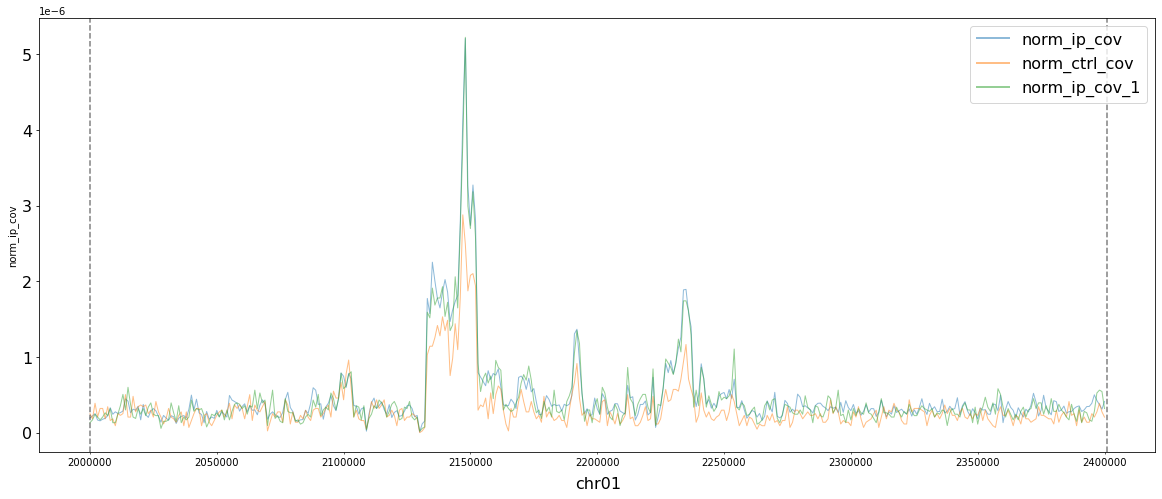

In [117]:
start = ("chr01", 2_000_000)  # 0) #
stop = ("chr01", 2_400_000)  # df.index.levels[1].max()) #
columns = [
    "norm_ip_cov",
    "norm_ctrl_cov",
    "norm_ip_cov_1",
]  # , 'sub_norm_ctrl_cov']#, 'norm_input_cov']
xtick_positions = False
xtick_rotated = True
if start[0] == stop[0]:
    xtick_positions = True
    xtick_rotated = False

subdf = df.loc[start:stop, columns]
subdf.index = subdf.index.remove_unused_levels()
separators = np.insert(
    np.cumsum(np.array(subdf[columns[0]].groupby(level=0).count())), 0, 0
)
lim = 0.00005  # subdf.to_numpy().max() # min(np.quantile(subdf.to_numpy(), 0.99)*3, subdf.to_numpy().max()) #
# plot
ax = subdf.plot(
    figsize=(20, 8),
    ylabel=columns[0],
    # ylim=(0, lim),
    alpha=0.5,
    linewidth=1,
    fontsize=16,
)
# legend with different line width
leg = ax.legend(fontsize=16, loc="upper right")
for line in leg.get_lines():
    line.set_linewidth(2)
# Horizotal and vertical lines
for sep in separators:
    ax.axvline(x=sep, color="black", linestyle="--", alpha=0.5)
# Get default ticks for genome position
if xtick_positions:
    xticks = ax.get_xticks()
    xticks_minor = xticks[np.where((0 <= xticks) & (xticks <= separators[-1]))]
    xticklabels_minor = [subdf.index[int(t)][1] for t in xticks_minor]
    ax.set_xticks(xticks_minor, labels=xticklabels_minor, minor=True)
# Add ticks for chromosome
xticks = utils.moving_average(separators)
if xtick_rotated:
    rot = 90
    xticklabels = subdf.index.levels[0]
else:
    rot = 0
    xticklabels = list("\n" + subdf.index.levels[0])
ax.set_xticks(xticks, labels=xticklabels, rotation=rot, fontsize=16)
ax.tick_params(axis="x", which="major", bottom=False, top=False)
# Remove xlabel
ax.set_xlabel(None)
plt.show()
plt.close()

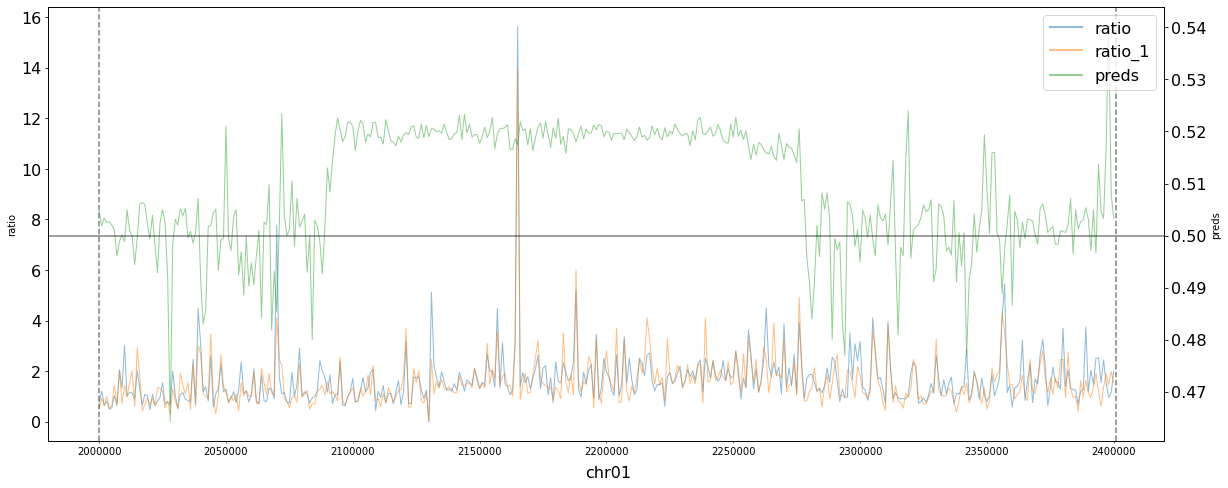

In [14]:
start = ("chr01", 2_000_000)
stop = ("chr01", 2_400_000)  # df.index.levels[1].max())
columns = [
    "ratio",
    "ratio_1",
]  # ['norm_ip_cov', 'norm_ctrl_cov']#, 'sub_norm_tot_cov'] # ['-log_qval'] #
columns2 = ["preds"]  # , 'sub_ctrl_count']
xtick_positions = False
xtick_rotated = True
if start[0] == stop[0]:
    xtick_positions = True
    xtick_rotated = False

subdf = df.loc[start:stop, columns + columns2]
subdf.index = subdf.index.remove_unused_levels()
separators = np.insert(
    np.cumsum(np.array(subdf[columns[0]].groupby(level=0).count())), 0, 0
)
# lim = min(np.quantile(subdf.loc[:, columns].to_numpy(), 0.99)*3, subdf.loc[:, columns].to_numpy().max()) #
# plot
ax = subdf.loc[:, columns].plot(
    figsize=(20, 8),
    ylabel=columns[0],
    # ylim=(0, lim),
    alpha=0.5,
    linewidth=1,
    legend=False,
    fontsize=16,
)
ax2 = ax.twinx()
subdf.loc[:, columns2].plot(
    ax=ax2,
    ylabel=columns2[0],
    alpha=0.5,
    linewidth=1,
    color=colors[len(columns) : len(columns) + len(columns2)],
    include_bool=True,
    fontsize=16,
)
# legend with different line width
handles, labels = plot_utils.add_legend([ax, ax2])
leg = plt.legend(handles, labels, fontsize=16, loc="upper right")
for line in leg.get_lines():
    line.set_linewidth(2)
# Horizotal and vertical lines
for sep in separators:
    ax.axvline(x=sep, color="black", linestyle="--", alpha=0.5)
ax2.axhline(y=0.5, color="black", alpha=0.5)
# Get default ticks for genome position
if xtick_positions:
    xticks = ax.get_xticks()
    xticks_minor = xticks[np.where((0 <= xticks) & (xticks <= separators[-1]))]
    xticklabels_minor = [subdf.index[int(t)][1] for t in xticks_minor]
    ax.set_xticks(xticks_minor, labels=xticklabels_minor, minor=True)
# Add ticks for chromosome
xticks = utils.moving_average(separators)
if xtick_rotated:
    rot = 90
    xticklabels = subdf.index.levels[0]
else:
    rot = 0
    xticklabels = list("\n" + subdf.index.levels[0])
ax.set_xticks(xticks, labels=xticklabels, rotation=rot, fontsize=16)
ax.tick_params(axis="x", which="major", bottom=False, top=False)
# Remove xlabel
ax.set_xlabel(None)
plt.show()
plt.close()

In [15]:
print(pearsonr(df["ratio"], df["preds"]))
print(pearsonr(df["ratio_1"], df["preds"]))

(0.0586711660119813, 0.0)
(0.20888256115555132, 0.0)


Compare with macs peaks

In [16]:
# peaks_dict = utils.parse_bed_peaks(Path(data_dir, data, 'peaks', 'expo_IP_vs_untagged_cer_reps_peaks.narrowPeak'))
peaks_dict = utils.parse_bed_peaks(
    "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/macs_output/HN00205099_RawFASTQ_RPE1_WTH3K9me3_paired_peaks.broadPeak"
)
peaks_dict_ip1 = utils.parse_bed_peaks(
    "/home/alex/shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/macs_output/D1145C43_trimmed_paired_T2T_peaks.broadPeak"
)

In [17]:
print(peaks_dict["NC_060925.1"].shape)
print(peaks_dict["NC_060925.1"][:5])

(3247, 3)
[[  248  1559   295]
 [25237 26301    80]
 [35114 38039    41]
 [48122 49224    13]
 [50682 51190    16]]


In [18]:
for chr_id, peaks in peaks_dict.items():
    print(chr_id, peaks_dict_ip1[chr_id].shape, peaks.shape)

NC_060925.1 (1026, 3) (3247, 3)
NC_060926.1 (144, 3) (870, 3)
NC_060927.1 (170, 3) (726, 3)
NC_060928.1 (130, 3) (1193, 3)
NC_060929.1 (211, 3) (848, 3)
NC_060930.1 (172, 3) (715, 3)
NC_060931.1 (336, 3) (483, 3)
NC_060932.1 (83, 3) (482, 3)
NC_060933.1 (1691, 3) (4309, 3)
NC_060934.1 (323, 3) (540, 3)
NC_060935.1 (110, 3) (876, 3)
NC_060936.1 (114, 3) (580, 3)
NC_060937.1 (264, 3) (1839, 3)
NC_060938.1 (318, 3) (1542, 3)
NC_060939.1 (763, 3) (2960, 3)
NC_060940.1 (367, 3) (1700, 3)
NC_060941.1 (185, 3) (808, 3)
NC_060942.1 (212, 3) (384, 3)
NC_060943.1 (254, 3) (1097, 3)
NC_060944.1 (364, 3) (419, 3)
NC_060945.1 (375, 3) (1324, 3)
NC_060946.1 (612, 3) (1863, 3)
NC_060947.1 (143, 3) (484, 3)
NC_060948.1 (1, 3) (22, 3)


In [129]:
nb_overlap_ip2, nb_overlap_ip1, nb_no_overlap_ip2, nb_no_overlap_ip1 = 0, 0, 0, 0
for chr_id, p in peaks_dict.items():
    assert len(utils.self_overlapping_peaks(p)) == 0
    assert len(utils.self_overlapping_peaks(peaks_dict_ip1[chr_id])) == 0
    (
        (overlap_ip2, overlap_ip1),
        (no_overlap_ip2, no_overlap_ip1),
    ) = utils.overlapping_peaks(p, peaks_dict_ip1[chr_id])
    nb_overlap_ip2 += len(overlap_ip2)
    nb_overlap_ip1 += len(overlap_ip1)
    nb_no_overlap_ip2 += len(no_overlap_ip2)
    nb_no_overlap_ip1 += len(no_overlap_ip1)
print(
    f"IP2: {nb_overlap_ip2 + nb_no_overlap_ip2} peaks, of which {nb_overlap_ip2} match, {nb_no_overlap_ip2} don't"
)
print(
    f"IP1: {nb_overlap_ip1 + nb_no_overlap_ip1} peaks, of which {nb_overlap_ip1} match, {nb_no_overlap_ip1} don't"
)
print(
    f"macs peaks: {100*nb_overlap_ip2/(nb_overlap_ip2 + nb_no_overlap_ip2)}% in IP2 match {100*nb_overlap_ip1/(nb_overlap_ip1 + nb_no_overlap_ip1)}% in IP1"
)

IP2: 29311 peaks, of which 4811 match, 24500 don't
IP1: 8368 peaks, of which 6559 match, 1809 don't
macs peaks: 16.413633107024665% in IP2 match 78.381931166348% in IP1


In [130]:
n_ip2, n_ip1, n_match = 0, 0, 0
for chr_id, peaks in peaks_dict.items():
    idx = utils.indices_from_peaks(peaks)
    idx_ip1 = utils.indices_from_peaks(peaks_dict_ip1[chr_id])
    mask = np.zeros(max(np.max(idx), np.max(idx_ip1)) + 1, dtype=int)
    mask[idx] += 1
    mask[idx_ip1] += 1
    n_ip2 += len(idx)
    n_ip1 += len(idx_ip1)
    n_match += (mask == 2).sum()
print(
    f"IP2: {n_ip2} bases in peaks, IP1: {n_ip1} bases in peak and {n_match} bases in overlap"
)
print(f"macs bases: {100*n_match/n_ip2}% in IP2 match {100*n_match/n_ip1}% in IP1")

IP2: 80071795 bases in peaks, IP1: 7439027 bases in peak and 5401351 bases in overlap
macs bases: 6.7456349642217965% in IP2 match 72.60829944561299% in IP1


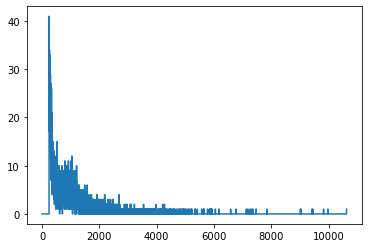

In [20]:
lengths_ip1 = []
for chr_id, p in peaks_dict_ip1.items():
    lengths_ip1.extend(p[:, 1] - p[:, 0])
val_ip1, counts_ip1 = np.unique(lengths_ip1, return_counts=True)
full_counts_ip1 = np.zeros(val_ip1[-1] + 1, dtype=int)
np.add.at(full_counts_ip1, val_ip1, counts_ip1)
plt.plot(full_counts_ip1)

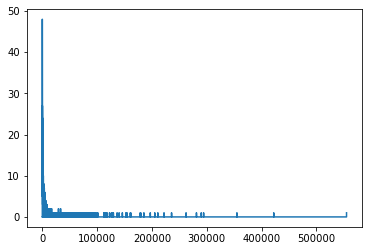

In [23]:
lengths = []
for chr_id, p in peaks_dict.items():
    lengths.extend(p[:, 1] - p[:, 0])
val, counts = np.unique(lengths, return_counts=True)
full_counts = np.zeros(val[-1] + 1, dtype=int)
np.add.at(full_counts, val, counts)
plt.plot(full_counts)

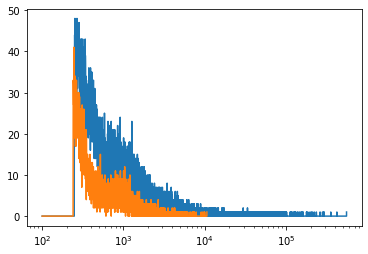

In [24]:
plt.plot(np.arange(100, len(full_counts)), full_counts[100:])
plt.plot(np.arange(100, len(full_counts_ip1)), full_counts_ip1[100:])
plt.xscale("log")

In [27]:
p = peaks_dict["NC_060925.1"]
print(p[(p[:, 1] - p[:, 0]) > 100_000])
p[(p[:, 1] - p[:, 0]) > 100_000, 1] - p[(p[:, 1] - p[:, 0]) > 100_000, 0]

[[124155747 124284999        96]
 [124996491 125142619        79]
 [126439205 126562011        45]]


array([129252, 146128, 122806])

In [28]:
df

ip_count  ctrl_count      pval      qval   norm_ip_cov  \
chr   pos                                                                
chr01 0            178.0        14.0  0.301472  0.974045  3.855145e-07   
      1000         296.0        15.0  0.007003  0.231759  6.410803e-07   
      2000          20.0         1.0  0.446400  1.000000  4.331623e-08   
      3000         160.0        16.0  0.644306  1.000000  3.465299e-07   
      4000         199.0        15.0  0.235309  0.899257  4.309965e-07   
...                  ...         ...       ...       ...           ...   
chrY  62456000     146.0         6.0  0.019337  0.347935  3.162085e-07   
      62457000     110.0         4.0  0.026670  0.395049  2.382393e-07   
      62458000     123.0        11.0  0.504352  1.000000  2.663948e-07   
      62459000     110.0         3.0  0.009621  0.262164  2.382393e-07   
      62460000       0.0         0.0  1.000000  1.000000  0.000000e+00   

                norm_ctrl_cov     ratio  signif_pval  signif_qval  -log_pval  \
chr   pos                                                                      
chr01 0          3.198247e-07  1.205393        False        False   0.520753   
      1000       3.426693e-07  1.870842         True        False   2.154717   
      2000       2.284462e-08  1.896124        False        False   0.350276   
      3000       3.655140e-07  0.948062        False        False   0.190908   
      4000       3.426693e-07  1.257762        False        False   0.628362   
...                       ...       ...          ...          ...        ...   
chrY  62456000   1.370677e-07  2.306951         True        False   1.713605   
      62457000   9.137849e-08  2.607170         True        False   1.573983   
      62458000   2.512909e-07  1.060106        False        False   0.297266   
      62459000   6.853387e-08  3.476227         True        False   2.016801   
      62460000   0.000000e+00  0.000000        False        False  -0.000000   

                ...  ip_count_1    pval_1    qval_1  norm_ip_cov_1   ratio_1  \
chr   pos       ...                                                            
chr01 0         ...          20  0.391354  1.000000   3.745363e-07  1.171068   
      1000      ...          23  0.300416  1.000000   4.307168e-07  1.256946   
      2000      ...           2  0.573986  1.000000   3.745363e-08  1.639495   
      3000      ...          19  0.600031  1.000000   3.558095e-07  0.973450   
      4000      ...          25  0.212312  0.989413   4.681704e-07  1.366245   
...             ...         ...       ...       ...            ...       ...   
chrY  62456000  ...           9  0.450551  1.000000   1.685414e-07  1.229621   
      62457000  ...           6  0.503068  1.000000   1.123609e-07  1.229621   
      62458000  ...           6  0.969607  1.000000   1.123609e-07  0.447135   
      62459000  ...          14  0.018261  0.468298   2.621754e-07  3.825487   
      62460000  ...           0  1.000000  1.000000   0.000000e+00  0.000000   

                signif_pval_1  signif_qval_1  -log_pval_1  -log_qval_1  \
chr   pos                                                                
chr01 0                 False          False     0.407430    -0.000000   
      1000              False          False     0.522278    -0.000000   
      2000              False          False     0.241098    -0.000000   
      3000              False          False     0.221826    -0.000000   
      4000              False          False     0.673025     0.004622   
...                       ...            ...          ...          ...   
chrY  62456000          False          False     0.346256    -0.000000   
      62457000          False          False     0.298374    -0.000000   
      62458000          False          False     0.013404    -0.000000   
      62459000           True          False     1.738478     0.329478   
      62460000          False          False    -0.000000    -0.000000   

        

In [112]:
df["macs_peak_1"] = 0
for chr_id, peaks in peaks_dict_ip1.items():
    # Get indices of starting and ending bins for chromosome peaks
    chr_peaks = peaks[:, :2].copy()
    chr_peaks[:, 0] //= binsize
    chr_peaks[:, 1] = (chr_peaks[:, 1] - 1) // binsize + 1
    # other option: np.digitize(peaks[:,:2], bins=df.index.levels[1]) - 1
    # Get all indices of bins overlapping with a peak and assigning 1
    idx = utils.indices_from_peaks(chr_peaks)
    df_chr_id = T2T_to_ucsc[chr_id]
    if df_chr_id[3:].isnumeric():
        df_chr_id = "chr" + format(int(df_chr_id[3:]), "02d")
    df.loc[df_chr_id, "macs_peak_1"].loc[idx * binsize] = 1
    # other option: df.loc[pd.IndexSlice[df_chr_id, idx * binsize], "macs_peak_1"] = 1
df

/home/alex/anaconda3/envs/tf2.5/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


ip_count  ctrl_count      pval      qval   norm_ip_cov  \
chr   pos                                                                
chr01 0            178.0        14.0  0.301472  0.974045  3.855145e-07   
      1000         296.0        15.0  0.007003  0.231759  6.410803e-07   
      2000          20.0         1.0  0.446400  1.000000  4.331623e-08   
      3000         160.0        16.0  0.644306  1.000000  3.465299e-07   
      4000         199.0        15.0  0.235309  0.899257  4.309965e-07   
...                  ...         ...       ...       ...           ...   
chrY  62456000     146.0         6.0  0.019337  0.347935  3.162085e-07   
      62457000     110.0         4.0  0.026670  0.395049  2.382393e-07   
      62458000     123.0        11.0  0.504352  1.000000  2.663948e-07   
      62459000     110.0         3.0  0.009621  0.262164  2.382393e-07   
      62460000       0.0         0.0  1.000000  1.000000  0.000000e+00   

                norm_ctrl_cov     ratio  signif_pval  signif_qval  -log_pval  \
chr   pos                                                                      
chr01 0          3.198247e-07  1.205393        False        False   0.520753   
      1000       3.426693e-07  1.870842         True        False   2.154717   
      2000       2.284462e-08  1.896124        False        False   0.350276   
      3000       3.655140e-07  0.948062        False        False   0.190908   
      4000       3.426693e-07  1.257762        False        False   0.628362   
...                       ...       ...          ...          ...        ...   
chrY  62456000   1.370677e-07  2.306951         True        False   1.713605   
      62457000   9.137849e-08  2.607170         True        False   1.573983   
      62458000   2.512909e-07  1.060106        False        False   0.297266   
      62459000   6.853387e-08  3.476227         True        False   2.016801   
      62460000   0.000000e+00  0.000000        False        False  -0.000000   

                ...    qval_1  norm_ip_cov_1   ratio_1  signif_pval_1  \
chr   pos       ...                                                     
chr01 0         ...  1.000000   3.745363e-07  1.171068          False   
      1000      ...  1.000000   4.307168e-07  1.256946          False   
      2000      ...  1.000000   3.745363e-08  1.639495          False   
      3000      ...  1.000000   3.558095e-07  0.973450          False   
      4000      ...  0.989413   4.681704e-07  1.366245          False   
...             ...       ...            ...       ...            ...   
chrY  62456000  ...  1.000000   1.685414e-07  1.229621          False   
      62457000  ...  1.000000   1.123609e-07  1.229621          False   
      62458000  ...  1.000000   1.123609e-07  0.447135          False   
      62459000  ...  0.468298   2.621754e-07  3.825487           True   
      62460000  ...  1.000000   0.000000e+00  0.000000          False   

                signif_qval_1  -log_pval_1  -log_qval_1     preds  \
chr   pos                                                           
chr01 0                 False     0.407430    -0.000000  0.483197   
      1000              False     0.522278    -0.000000  0.508549   
      2000              False     0.241098    -0.000000  0.477649   
      3000              False     0.221826    -0.000000  0.474256   
      4000              False     0.673025     0.004622  0.487874   
...                       ...          ...          ...       ...   
chrY  62456000          False     0.346256    -0.000000  0.507194   
      62457000          False     0.298374    -0.000000  0.507313   
      62458000          False     0.013404    -0.000000  0.507376   
      62459000          False     1.738478     0.329478  0.496686   
      62460000          False    -0.000000    -0.000000  0.000000   

                macs_peak_1  macs_peak  
chr   pos                               
chr01 0                   0          1  
      1000                0          1  


In [113]:
df["macs_peak"] = 0
for chr_id, peaks in peaks_dict.items():
    # Get indices of starting and ending bins for chromosome peaks
    chr_peaks = peaks[:, :2].copy()
    chr_peaks[:, 0] //= binsize
    chr_peaks[:, 1] = (chr_peaks[:, 1] - 1) // binsize + 1
    # other option: np.digitize(peaks[:,:2], bins=df.index.levels[1]) - 1
    # Get all indices of bins overlapping with a peak and assigning 1
    idx = utils.indices_from_peaks(chr_peaks)
    df_chr_id = T2T_to_ucsc[chr_id]
    if df_chr_id[3:].isnumeric():
        df_chr_id = "chr" + format(int(df_chr_id[3:]), "02d")
    df.loc[df_chr_id, "macs_peak"].loc[idx * binsize] = 1
    # other option: df.loc[pd.IndexSlice[df_chr_id, idx * binsize], "macs_peak"] = 1
df

/home/alex/anaconda3/envs/tf2.5/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


ip_count  ctrl_count      pval      qval   norm_ip_cov  \
chr   pos                                                                
chr01 0            178.0        14.0  0.301472  0.974045  3.855145e-07   
      1000         296.0        15.0  0.007003  0.231759  6.410803e-07   
      2000          20.0         1.0  0.446400  1.000000  4.331623e-08   
      3000         160.0        16.0  0.644306  1.000000  3.465299e-07   
      4000         199.0        15.0  0.235309  0.899257  4.309965e-07   
...                  ...         ...       ...       ...           ...   
chrY  62456000     146.0         6.0  0.019337  0.347935  3.162085e-07   
      62457000     110.0         4.0  0.026670  0.395049  2.382393e-07   
      62458000     123.0        11.0  0.504352  1.000000  2.663948e-07   
      62459000     110.0         3.0  0.009621  0.262164  2.382393e-07   
      62460000       0.0         0.0  1.000000  1.000000  0.000000e+00   

                norm_ctrl_cov     ratio  signif_pval  signif_qval  -log_pval  \
chr   pos                                                                      
chr01 0          3.198247e-07  1.205393        False        False   0.520753   
      1000       3.426693e-07  1.870842         True        False   2.154717   
      2000       2.284462e-08  1.896124        False        False   0.350276   
      3000       3.655140e-07  0.948062        False        False   0.190908   
      4000       3.426693e-07  1.257762        False        False   0.628362   
...                       ...       ...          ...          ...        ...   
chrY  62456000   1.370677e-07  2.306951         True        False   1.713605   
      62457000   9.137849e-08  2.607170         True        False   1.573983   
      62458000   2.512909e-07  1.060106        False        False   0.297266   
      62459000   6.853387e-08  3.476227         True        False   2.016801   
      62460000   0.000000e+00  0.000000        False        False  -0.000000   

                ...    qval_1  norm_ip_cov_1   ratio_1  signif_pval_1  \
chr   pos       ...                                                     
chr01 0         ...  1.000000   3.745363e-07  1.171068          False   
      1000      ...  1.000000   4.307168e-07  1.256946          False   
      2000      ...  1.000000   3.745363e-08  1.639495          False   
      3000      ...  1.000000   3.558095e-07  0.973450          False   
      4000      ...  0.989413   4.681704e-07  1.366245          False   
...             ...       ...            ...       ...            ...   
chrY  62456000  ...  1.000000   1.685414e-07  1.229621          False   
      62457000  ...  1.000000   1.123609e-07  1.229621          False   
      62458000  ...  1.000000   1.123609e-07  0.447135          False   
      62459000  ...  0.468298   2.621754e-07  3.825487           True   
      62460000  ...  1.000000   0.000000e+00  0.000000          False   

                signif_qval_1  -log_pval_1  -log_qval_1     preds  \
chr   pos                                                           
chr01 0                 False     0.407430    -0.000000  0.483197   
      1000              False     0.522278    -0.000000  0.508549   
      2000              False     0.241098    -0.000000  0.477649   
      3000              False     0.221826    -0.000000  0.474256   
      4000              False     0.673025     0.004622  0.487874   
...                       ...          ...          ...       ...   
chrY  62456000          False     0.346256    -0.000000  0.507194   
      62457000          False     0.298374    -0.000000  0.507313   
      62458000          False     0.013404    -0.000000  0.507376   
      62459000          False     1.738478     0.329478  0.496686   
      62460000          False    -0.000000    -0.000000  0.000000   

                macs_peak_1  macs_peak  
chr   pos                               
chr01 0                   0          1  
      1000                0          1  


In [117]:
pval_ip2, pval_ip1, pval_both, macs_ip2, macs_ip1, macs_both = 0, 0, 0, 0, 0, 0
for chr_id in df.index.levels[0]:
    pval_ip2 += np.sum(df.loc[(chr_id,), "signif_pval"])
    pval_ip1 += np.sum(df.loc[(chr_id,), "signif_pval_1"])
    pval_both += np.sum(
        (df.loc[(chr_id,), "signif_pval"]) & (df.loc[(chr_id,), "signif_pval_1"])
    )
    macs_ip2 += np.sum(df.loc[(chr_id,), "macs_peak"])
    macs_ip1 += np.sum(df.loc[(chr_id,), "macs_peak_1"])
    macs_both += np.sum(
        (df.loc[(chr_id,), "macs_peak"]) & (df.loc[(chr_id,), "macs_peak_1"])
    )
print(f"pval: {100*pval_both/pval_ip2}% in IP2 match {100*pval_both/pval_ip1}% in IP1")
print(pval_ip2, pval_ip1, pval_both)
print(f"macs: {100*macs_both/macs_ip2}% in IP2 match {100*macs_both/macs_ip1}% in IP1")
print(macs_ip2, macs_ip1, macs_both)

pval: 40.17983847660119% in IP2 match 52.57832717877677% in IP1
307943 235327 123731
macs: 11.08926464805348% in IP2 match 77.13249793270148% in IP1
109349 15721 12126


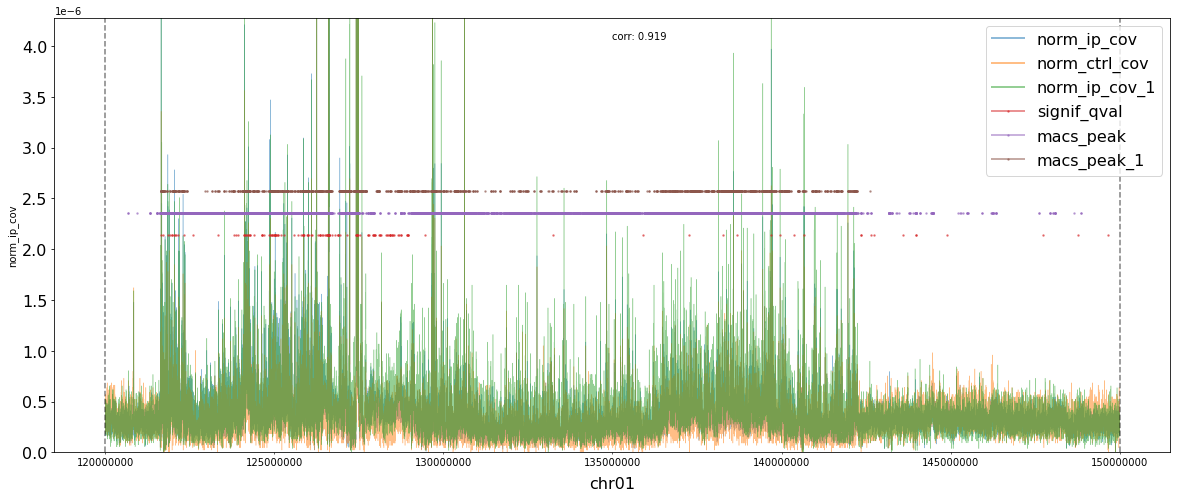

In [51]:
start = ("chr01", 120_000_000)
stop = ("chr01", 150_000_000)  # df.index.levels[1].max())
peak_columns = ["signif_qval", "macs_peak", "macs_peak_1"]
columns = ["norm_ip_cov", "norm_ctrl_cov", "norm_ip_cov_1"] + peak_columns
# columns = ['preds'] + peak_columns
xtick_positions = False
xtick_rotated = True
if start[0] == stop[0]:
    xtick_positions = True
    xtick_rotated = False

subdf = df.loc[start:stop, columns]
subdf.index = subdf.index.remove_unused_levels()
separators = np.insert(
    np.cumsum(np.array(subdf[columns[0]].groupby(level=0).count())), 0, 0
)
lim = min(np.quantile(subdf[columns[0]], 0.99) * 3, np.max(subdf[columns[0]]))  # 1.2 #
for i, peak_column in enumerate(peak_columns):
    subdf[peak_column] *= lim * (0.5 + 0.05 * i)
    subdf.loc[subdf[peak_column] == 0, peak_column] = None
# plot
ax = subdf.plot(
    figsize=(20, 8),
    xlabel="positions",
    ylabel=columns[0],
    ylim=(0, lim),
    alpha=0.5,
    linewidth=0.5,
    fontsize=16,
)
# set edge markers for peaks
for line in ax.get_lines():
    if line.get_label() in peak_columns:
        line.set_marker(".")
        line.set_markersize(3)
# legend with different line width
leg = ax.legend(fontsize=16, loc="upper right")
for line in leg.get_lines():
    line.set_linewidth(2)
# Horizotal and vertical lines
for sep in separators:
    ax.axvline(x=sep, color="black", linestyle="--", alpha=0.5)
# Get default ticks for genome position
if xtick_positions:
    xticks = ax.get_xticks()
    xticks_minor = xticks[np.where((0 <= xticks) & (xticks <= separators[-1]))]
    xticklabels_minor = [subdf.index[int(t)][1] for t in xticks_minor]
    ax.set_xticks(xticks_minor, labels=xticklabels_minor, minor=True)
# Add ticks for chromosome
xticks = utils.moving_average(separators)
if xtick_rotated:
    rot = 90
    xticklabels = subdf.index.levels[0]
else:
    rot = 0
    xticklabels = list("\n" + subdf.index.levels[0])
ax.set_xticks(xticks, labels=xticklabels, rotation=rot, fontsize=16)
ax.tick_params(axis="x", which="major", bottom=False, top=False)
# Remove xlabel
ax.set_xlabel(None)
local_corr = np.corrcoef(df.loc[start:stop, ["norm_ip_cov", "norm_ip_cov_1"]].T)[1, 0]
plt.annotate(f"corr: {round(local_corr, 3)}", xy=(0.5, 0.95), xycoords="axes fraction")
plt.show()
plt.close()

<AxesSubplot:>

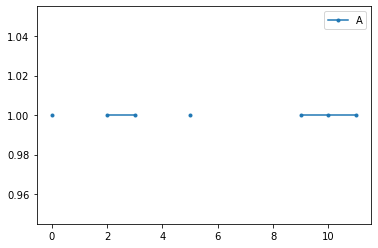

In [313]:
df_test = pd.DataFrame({"A": [1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0]})
df_test[df_test["A"] == 0] = None
df_test.plot(marker=".")

Deprecated plot

ValueError: The number of FixedLocator locations (1), usually from a call to set_ticks, does not match the number of ticklabels (16).

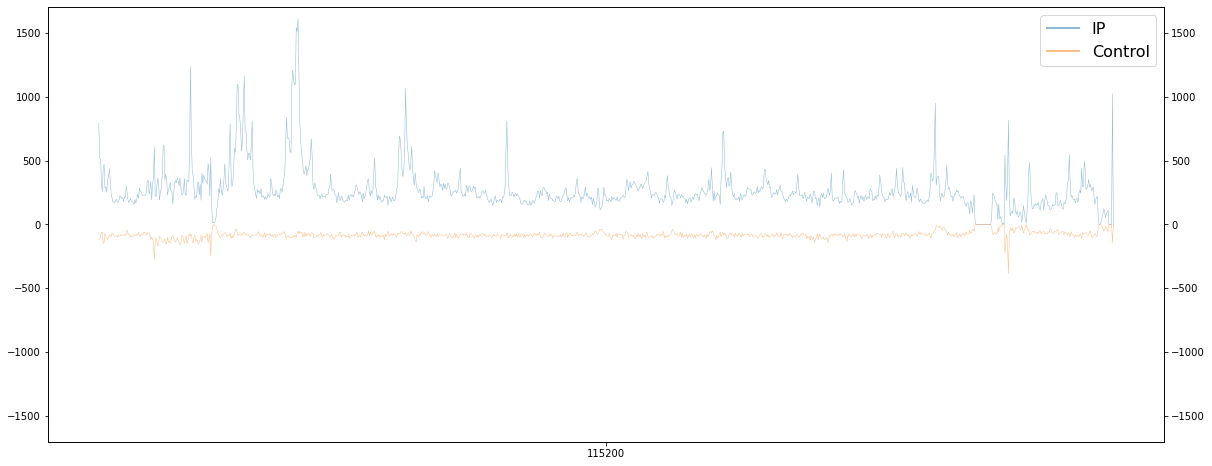

In [299]:
start = separators[0] * binsize  # + 138_000_000
stop = separators[-1] * binsize  # + 152_000_000
column = "ip_count"  # 'ip_count' # 'signif_qval'
column2 = "ctrl_count"
values_list = [df[column], -df[column2]]
label_list = ["IP", "Control"]

if genome == "T2T-CHM13v2.0":
    chr_ids = T2T_chr_ids
elif genome == "GRCh38":
    chr_ids = hg38_chr_ids
elif genome == "sacCer3":
    chr_ids = sacCer3_chr_ids
plt.figure(figsize=(20, 8))
axes = plot_utils.compare_binned_plots(
    values_list, label_list, start, stop, binsize, alpha=0.5, linewidth=0.5
)
lim = np.quantile(df[column], 0.99) * 1.5  # 1
axes[0].set_ylim(bottom=-lim, top=lim)
axes[1].set_ylim(bottom=-lim, top=lim)
for sep in separators[1:-1]:
    plt.axvline(x=sep * binsize, color="black", linestyle="--", alpha=0.5)
axes[0].set_xticks(utils.moving_average(separators * binsize)[:])
axes[0].set_xticklabels(list(chr_ids.keys())[:], fontsize=16)
axes[0].set_xlabel("chromosome", fontsize=16)
axes[0].set_ylabel("coverage", fontsize=16)
plt.axhline(y=0, color="black")
plt.show()
plt.close()

<AxesSubplot:title={'center':'Significant p-value distribution on CTCF with binsize 50 and full coverage'}, ylabel='Frequency'>

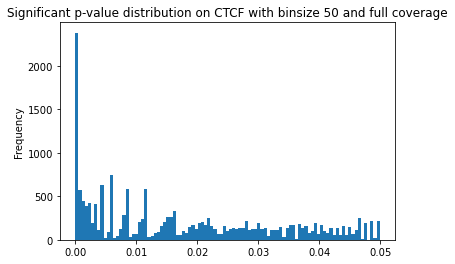

In [ ]:
df["pval"][df["pval"] < 0.05].plot(
    kind="hist",
    bins=97,
    grid=False,
    xlabel="p-value",
    title=f"Significant p-value distribution on CTCF with binsize {binsize} and full coverage",
)

<AxesSubplot:title={'center':'Significant p-value distribution on CTCF with binsize 50 and full coverage'}, ylabel='Frequency'>

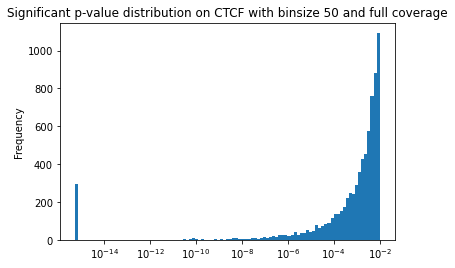

In [ ]:
subdf = df["pval"][df["pval"] < 1e-2]
logbins = np.geomspace(subdf.min(), subdf.max(), 100)
subdf.plot(
    kind="hist",
    bins=logbins,
    grid=False,
    logx=True,
    xlabel="p-value",
    title=f"Significant p-value distribution on CTCF with binsize {binsize} and full coverage",
)

In [ ]:
subdf = df[(df["pval"] < 1e-15)].loc[:, ["ip_count", "ctrl_count", "pval"]]
print(len(subdf[subdf["ip_count"] >= 30]), len(subdf))
subdf

2888 3134


,ip_count,ctrl_count,pval
74,34.0,0.0,1.110223e-16
76,33.0,1.0,1.110223e-16
727,50.0,5.0,1.110223e-16
728,46.0,6.0,1.110223e-16
737,38.0,4.0,4.440892e-16
...,...,...,...
57930371,38.0,4.0,4.440892e-16
60078194,32.0,0.0,1.110223e-16
60078197,29.0,0.0,7.771561e-16
62345368,37.0,1.0,1.110223e-16


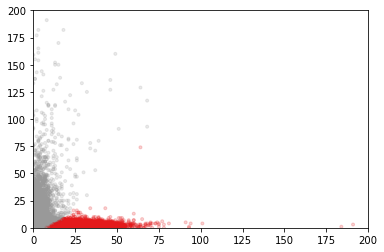

In [ ]:
# Show significant enrichments based on ip and ctrl coverage
plt.scatter(
    df["ip_count"],
    df["ctrl_count"],
    c=df["signif_qval"],
    label="positions",
    cmap=plt.cm.get_cmap("Set1_r"),
    marker=".",
    alpha=0.2,
)
plt.xlim(left=0, right=200)
plt.ylim(bottom=0, top=200)
plt.show()
plt.close()

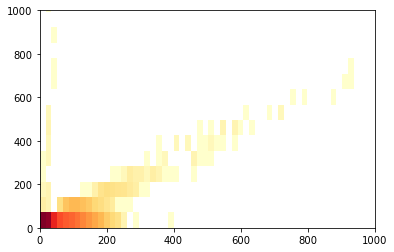

In [ ]:
_, bin_edges_x = np.histogram(df["ip_count"], bins=100)
_, bin_edges_y = np.histogram(df["ctrl_count"], bins=100)
bin_edges = [bin_edges_x, bin_edges_y]
plt.hist2d(
    df["ip_count"],
    df["ctrl_count"],
    bins=bin_edges,
    density=True,
    norm=mpl.colors.LogNorm(),
    cmap=plt.cm.get_cmap("YlOrRd"),
)
plt.xlim(left=0, right=1000)
plt.ylim(bottom=0, top=1000)
plt.show()
plt.close()

## Granularity analysis

In [ ]:
data = "RNAPII_quiescence"
genome = "sacCer3"
max_frag_len = 500
ip_prefix = "untagged_expo_IP_1"
ctrl_prefix = "untagged_expo_INPUT_1"
binsizes = [50, 200, 1000, 5000, 50000]
binsize = binsizes[0]
df_all = (
    pd.read_csv(
        Path(
            data_dir,
            data,
            "results",
            "alignments",
            genome,
            f"{data}_{genome}_{ip_prefix}_vs_{ctrl_prefix}_maxfraglen_{max_frag_len}_binsize_{binsize}.csv",
        ),
        index_col=[0, 1],
    )
    .rename(columns={"pval": f"pval_{binsize}", "qval": f"qval_{binsize}"})
    .drop(["ip_count", "ctrl_count"], axis=1)
)
for b in binsizes[1:]:
    df_adapt = pd.read_csv(
        Path(
            data_dir,
            data,
            "results",
            "alignments",
            genome,
            f"{data}_{genome}_{ip_prefix}_vs_{ctrl_prefix}_maxfraglen_{max_frag_len}_binsize_{b}.csv",
        ),
        index_col=[0, 1],
    )
    df_adapt = utils.adapt_to_bins(df_adapt, df_all, b, binsize).rename(
        columns={"pval": f"pval_{b}", "qval": f"qval_{b}"}
    )
    df_all.loc[:, [f"pval_{b}", f"qval_{b}"]] = df_adapt.loc[
        :, [f"pval_{b}", f"qval_{b}"]
    ]
df_all

pval_50   qval_50  pval_200  qval_200  pval_1000  qval_1000  \
chr    pos                                                                    
chrI   0       0.997846  1.000000  0.995415       1.0   0.999999        1.0   
       50      0.970665  1.000000  0.995415       1.0   0.999999        1.0   
       100     0.979718  1.000000  0.995415       1.0   0.999999        1.0   
       150     0.150004  1.000000  0.995415       1.0   0.999999        1.0   
       200     0.111407  0.919706  0.981166       1.0   0.999999        1.0   
...                 ...       ...       ...       ...        ...        ...   
chrXVI 947850  1.000000  1.000000  1.000000       1.0   1.000000        1.0   
       947900  1.000000  1.000000  1.000000       1.0   1.000000        1.0   
       947950  1.000000  1.000000  1.000000       1.0   1.000000        1.0   
       948000  1.000000  1.000000  1.000000       1.0   1.000000        1.0   
       948050  1.000000  1.000000  1.000000       1.0   1.000000        1.0   

               pval_5000  qval_5000  pval_50000  qval_50000  
chr    pos                                                   
chrI   0        1.000000        1.0         1.0         1.0  
       50       1.000000        1.0         1.0         1.0  
       100      1.000000        1.0         1.0         1.0  
       150      1.000000        1.0         1.0         1.0  
       200      1.000000        1.0         1.0         1.0  
...                  ...        ...         ...         ...  
chrXVI 947850   0.999989        1.0         1.0         1.0  
       947900   0.999989        1.0         1.0         1.0  
       947950   0.999989        1.0         1.0         1.0  
       948000   0.999989        1.0         1.0         1.0  
       948050   0.999989        1.0         1.0         1.0  

[241434 rows x 10 columns]

In [ ]:
key = "p"
df_signif = (
    df_all.loc[:, [f"{key}val_{b}" for b in [50, 200, 1000, 5000, 50000]]] < 0.05
)
signif_by_binsize = df_signif.sum(axis=0)
signif_by_pos = df_signif.sum(axis=1)
signif_by_binsize

pval_50       18111
pval_200      32548
pval_1000     45000
pval_5000     29700
pval_50000     2000
dtype: int64

In [ ]:
tuples = [(1, 0), (1, 50), (1, 100), (2, 0), (3, 0), (3, 50)]
index = pd.MultiIndex.from_tuples(tuples)
pd.Series(np.random.randn(6), index=index)

1  0     -0.012333
   50    -0.350264
   100   -0.049656
2  0     -0.313436
3  0      0.725239
   50    -0.779801
dtype: float64

In [ ]:
# index = pd.MultiIndex()
chr_lens = {"chr1": 246, "chr2": 132, "chr3": 196}
binsize = 50
binned_chr_lens = np.array([x // binsize + 1 for x in chr_lens.values()])

index = pd.MultiIndex.from_tuples(
    [
        (chr_id, pos)
        for chr_id in np.arange(len(chr_lens))
        for pos in np.arange(0, binned_chr_lens[chr_id] * binsize, binsize)
    ],
    names=["chr", "pos"],
)
index

MultiIndex([(0,   0),
            (0,  50),
            (0, 100),
            (0, 150),
            (0, 200),
            (1,   0),
            (1,  50),
            (1, 100),
            (2,   0),
            (2,  50),
            (2, 100),
            (2, 150)],
           names=['chr', 'pos'])

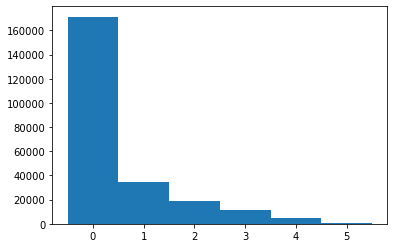

[171381  34905  18619  11339   4751    439]


In [ ]:
plt.hist(signif_by_pos, bins=np.arange(-0.5, 6.5))
plt.show()
plt.close()
print(np.histogram(signif_by_pos, bins=np.arange(-0.5, 6.5))[0])

In [ ]:
df_coincide = pd.DataFrame(index=binsizes, columns=np.arange(5))
for b in df_coincide.index:
    for l in df_coincide.columns:
        df_coincide.loc[b, l] = len(
            df_signif[(df_signif[f"{key}val_{b}"] == 1) & (signif_by_pos == l + 1)]
        )
csv_name = utils.safe_filename(
    Path(
        data_dir,
        data,
        "results",
        "alignments",
        genome,
        f"{data}_enrichment_coincidence_{key}val.csv",
    )
)
df_coincide.to_csv(csv_name)
df_coincide

,0,1,2,3,4
50,3125,3624,6241,4682,439
200,5339,11282,10747,4741,439
1000,14037,14920,10865,4739,439
5000,11524,7050,5970,4717,439
50000,880,362,194,125,439


In [ ]:
# df_signif.groupby(df_signif.columns.tolist(), as_index=False).size()
df_signif.value_counts()

pval_50  pval_200  pval_1000  pval_5000  pval_50000
False    False     False      False      False         171381
                   True       False      False          14037
                   False      True       False          11524
         True      True       False      False           8114
         False     True       True       False           5730
         True      False      False      False           5339
True     True      True       False      False           5318
False    True      True       True       False           4930
True     True      True       True       False           4626
         False     False      False      False           3125
         True      False      False      False           2329
         False     True       False      False            991
False    False     False      False      True             880
         True      False      True       False            805
True     False     True       True       False            454
         True     

In [ ]:
df_signif.columns[1:]

Index(['pval_200', 'pval_1000', 'pval_5000', 'pval_50000'], dtype='object')

In [ ]:
df_signif.groupby(df_signif.columns.tolist(), as_index=False).size()

,pval_50,pval_200,pval_1000,pval_5000,pval_50000,size
0,False,False,False,False,False,171381
1,False,False,False,False,True,880
2,False,False,False,True,False,11524
3,False,False,False,True,True,227
4,False,False,True,False,False,14037
5,False,False,True,False,True,85
6,False,False,True,True,False,5730
7,False,False,True,True,True,122
8,False,True,False,False,False,5339
9,False,True,False,False,True,34


## Downsample analysis

In [55]:
max_frag_len = 500
binsizes = [10_000_000, 2_000_000, 500_000]
# fracs = np.linspace(0.01, 1, 10)
divs = 2 ** np.arange(9)  # [1, 1.2, 1.5, 2, 3, 4]

data = "Judith-H3K9me3"  # "RNAPII_quiescence" #
genome = "T2T-CHM13v2.0"  # "sacCer3" #
# ip_prefix = "WT_6d_IP_1"
# ctrl_prefix = "untagged_6d_IP_1"
basename = "IP2_"  # f"{ip_prefix}_vs_{ctrl_prefix}_"  # '' #
suffix = "_2pow1to256_binsupto10M"

IP2_enrichments = utils.downsample_enrichment_analysis(
    data,
    genome,
    max_frag_len,
    binsizes,
    # fracs=fracs,
    divs=divs,
    reverse=True,
    basename=basename,
    use_fdr=False,
)
file = Path(
    data_dir,
    data,
    "results",
    "alignments",
    genome,
    f"{data}_{basename}downsample_enrichments_pval{suffix}.csv",
)
if not file.is_file():
    IP2_enrichments.to_csv(file)
    print(f"{file} saved")
IP2_enrichments = utils.downsample_enrichment_analysis(
    data,
    genome,
    max_frag_len,
    binsizes,
    # fracs=fracs,
    divs=divs,
    reverse=True,
    basename=basename,
    use_fdr=True,
)
file = Path(
    data_dir,
    data,
    "results",
    "alignments",
    genome,
    f"{data}_{basename}downsample_enrichments_qval{suffix}.csv",
)
if not file.is_file():
    IP2_enrichments.to_csv(file)
    print(f"{file} saved")

../shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/Judith-H3K9me3_IP2_downsample_enrichments_pval_2pow1to256_binsupto10M.csv saved
../shared_folder/Judith-H3K9me3/results/alignments/T2T-CHM13v2.0/Judith-H3K9me3_IP2_downsample_enrichments_qval_2pow1to256_binsupto10M.csv saved


In [56]:
# data = 'RNAPII_quiescence' # 'Judith-H3K4me3' #
# genome = 'sacCer3' # 'T2T-CHM13v2.0' #
# ip_prefix = 'WT_expo_IP_1'
# ctrl_prefix = 'untagged_expo_IP_1'
# basename = f'{ip_prefix}_vs_{ctrl_prefix}_' # '' #
# H3K4me3_enrichments = pd.read_csv(Path(data_dir, 'Judith-H3K4me3', 'results', 'alignments', genome, 'Judith-H3K4me3_downsample_enrichments_v5_pval_fine_resolution.csv'), index_col=[0, 1])
# H3K9me3_enrichments = pd.read_csv(Path(data_dir, 'Judith-H3K9me3', 'results', 'alignments', genome, 'Judith-H3K9me3_downsample_enrichments_v5_pval_fine_resolution.csv'), index_col=[0, 1])
IP2_enrichments = {}
IP2_enrichments["q"] = pd.read_csv(
    Path(
        data_dir,
        data,
        "results",
        "alignments",
        genome,
        f"{data}_{basename}downsample_enrichments_qval{suffix}.csv",
    ),
    index_col=[0, 1],
)
IP2_enrichments["p"] = pd.read_csv(
    Path(
        data_dir,
        data,
        "results",
        "alignments",
        genome,
        f"{data}_{basename}downsample_enrichments_pval{suffix}.csv",
    ),
    index_col=[0, 1],
)

binsizes = list(IP2_enrichments["p"].index.levels[0])
IP2_enrichments

{'q':                      IP  IP_clust  Undetermined  Ctrl  Ctrl_clust    total_cov
 10000000 1.000000   139        51            15   173          47  505494633.0
          0.500000   136        51            17   174          47  252747316.0
          0.250000   134        52            23   170          48  126373658.0
          0.125000   131        56            29   167          46   63186829.0
          0.062500   118        51            55   154          42   31593415.0
          0.031250   111        53            73   143          46   15796707.0
          0.015625   102        51            97   128          47    7898353.0
          0.007812    85        50           145    97          46    3949177.0
          0.003906    55        43           211    61          32    1974588.0
 2000000  1.000000   561       200            85   927         198  505494633.0
          0.500000   545       198           120   908         205  252747316.0
          0.250000   531       196 

In [57]:
# H3K9me3_enrichments['sig_perc'] = 100 * (H3K9me3_enrichments['IP'] + H3K9me3_enrichments['Ctrl']) / H3K9me3_enrichments[['IP', 'Undetermined', 'Ctrl']].sum(axis=1)
# H3K9me3_enrichments['IP_perc'] = 100 * (H3K9me3_enrichments['IP']) / H3K9me3_enrichments[['IP', 'Undetermined', 'Ctrl']].sum(axis=1)
for (
    temp_df
) in IP2_enrichments.values():  # [H3K9me3_enrichments, H3K4me3_enrichments]: #
    temp_df["sig_perc"] = (
        100
        * (temp_df["IP"] + temp_df["Ctrl"])
        / temp_df[["IP", "Undetermined", "Ctrl"]].sum(axis=1)
    )
    temp_df["IP_perc"] = (
        100 * (temp_df["IP"]) / temp_df[["IP", "Undetermined", "Ctrl"]].sum(axis=1)
    )

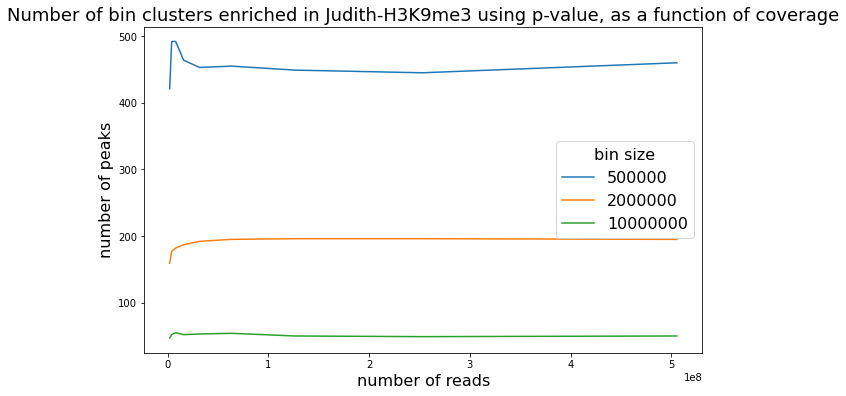

In [58]:
key = "p"
plt.figure(figsize=(10, 6), facecolor="w")
for b in binsizes[:]:
    plt.plot(
        IP2_enrichments[key].loc[b, "total_cov"],
        IP2_enrichments[key].loc[b, "IP_clust"],
        label=b,
    )
plt.legend(fontsize=16, title="bin size", title_fontsize=16)
# plt.title(f"Number of peaks enriched in H3K9me3_2023 as a function of coverage", fontsize=18)
plt.title(
    f"Number of bin clusters enriched in {data} using {key}-value, as a function of coverage",
    fontsize=18,
)
plt.xlabel("number of reads", fontsize=16)
plt.ylabel("number of peaks", fontsize=16)
# plt.xscale('log')
# plt.yscale('log')
fig_name = Path(
    data_dir,
    data,
    "results",
    "alignments",
    genome,
    f"{data}_{basename}n_clusters_vs_coverage_{key}val{suffix}.png",
)
# fig_name = utils.safe_filename(fig_name)
# plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

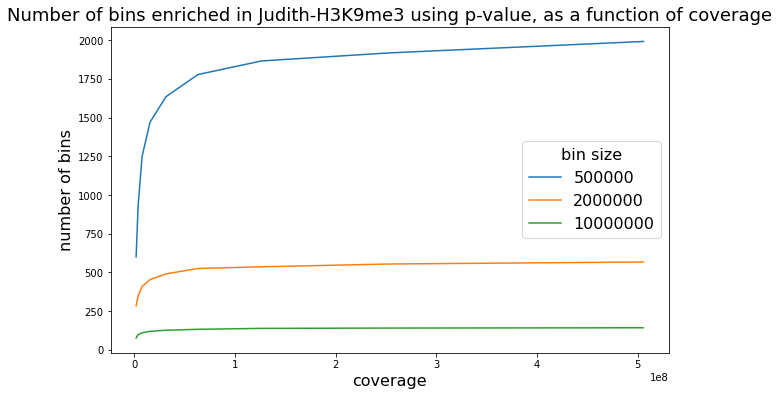

In [59]:
key = "p"
plt.figure(figsize=(10, 6), facecolor="w")
for b in binsizes:
    plt.plot(
        IP2_enrichments[key].loc[b, "total_cov"],
        IP2_enrichments[key].loc[b, "IP"],
        label=b,
    )
plt.legend(fontsize=16, title="bin size", title_fontsize=16)
plt.title(
    f"Number of bins enriched in {data} using {key}-value, as a function of coverage",
    fontsize=18,
)
plt.xlabel("coverage", fontsize=16)
plt.ylabel("number of bins", fontsize=16)
# plt.xscale('log')
# plt.yscale('log')
fig_name = Path(
    data_dir,
    data,
    "results",
    "alignments",
    genome,
    f"{data}_{basename}n_bins_vs_coverage_{key}val{suffix}.png",
)
# fig_name = utils.safe_filename(fig_name)
# plt.savefig(fig_name, bbox_inches="tight")
plt.show()
plt.close()

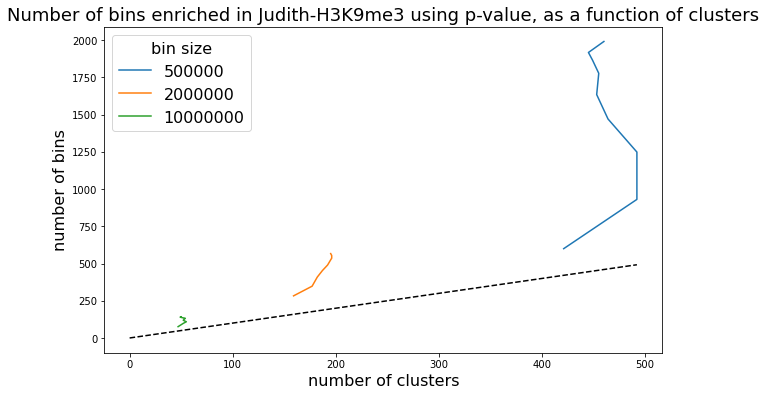

In [60]:
key = "p"
plt.figure(figsize=(10, 6), facecolor="w")
for b in binsizes:
    plt.plot(
        IP2_enrichments[key].loc[b, "IP_clust"],
        IP2_enrichments[key].loc[b, "IP"],
        label=b,
    )
max_clust = np.max(IP2_enrichments[key]["IP_clust"])
plt.plot([0, max_clust], [0, max_clust], color="black", linestyle="--")
plt.legend(fontsize=16, title="bin size", title_fontsize=16)
plt.title(
    f"Number of bins enriched in {data} using {key}-value, as a function of clusters",
    fontsize=18,
)
plt.xlabel("number of clusters", fontsize=16)
plt.ylabel("number of bins", fontsize=16)
# plt.yscale('log')
fig_name = Path(
    data_dir,
    data,
    "results",
    "alignments",
    genome,
    f"{data}_{basename}n_bins_vs_n_clusters_{key}val{suffix}.png",
)
# fig_name = utils.safe_filename(fig_name)
# plt.savefig(fig_name, bbox_inches="tight")
plt.show()
plt.close()

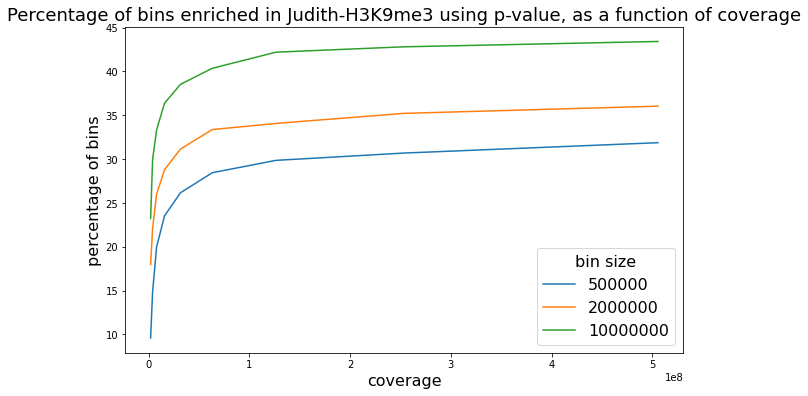

In [61]:
key = "p"
plt.figure(figsize=(10, 6), facecolor="w")
for b in binsizes[:]:
    plt.plot(
        IP2_enrichments[key].loc[b, "total_cov"],
        IP2_enrichments[key].loc[b, "IP_perc"],
        label=b,
    )
plt.legend(fontsize=16, title="bin size", title_fontsize=16)
plt.title(
    f"Percentage of bins enriched in {data} using {key}-value, as a function of coverage",
    fontsize=18,
)
plt.xlabel("coverage", fontsize=16)
plt.ylabel("percentage of bins", fontsize=16)
# plt.xscale("log")
# plt.yscale('log')
fig_name = Path(
    data_dir,
    data,
    "results",
    "alignments",
    genome,
    f"{data}_{basename}bin_percentage_vs_coverage_{key}val{suffix}.png",
)
# fig_name = utils.safe_filename(fig_name)
# plt.savefig(fig_name, bbox_inches="tight")
plt.show()
plt.close()

## Rechem comparisons

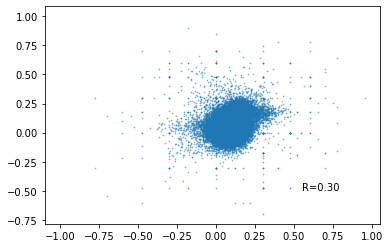

In [ ]:
i = 3
Rechem_rep1 = H3K9me3_Rechem[i]["log_ratio"]
Rechem_rep2 = H3K9me3_Rechem[i + 4]["log_ratio"]
valid_bins = np.logical_and(np.isfinite(Rechem_rep1), np.isfinite(Rechem_rep2))
corr, _ = pearsonr(Rechem_rep1[valid_bins], Rechem_rep2[valid_bins])
plt.scatter(Rechem_rep1, Rechem_rep2, s=0.5, alpha=0.5)
plt.annotate("R={0:1.2f}".format(corr), xy=(0.7, 0.2), xycoords="figure fraction")
plt.plot([-1, -1], [1, 1], color="black")  # , alpha=0.5)
plt.show()
plt.close()

Number of reads

In [ ]:
print(np.sum(full_genome_H3K9me3["ip_binned_signal"]), "in H3K9me3")
print(np.sum(full_genome_H3K9me3["ctrl_binned_signal"]), "in INPUT-H3K9me3")
print(np.sum(full_genome_H3K4me3["ip_binned_signal"]), "in H3K4me3")
print(np.sum(full_genome_H3K4me3["ctrl_binned_signal"]), "in INPUT-H3K4me3")
data = "H3K9me3-GSE175752"
for i, H3K9me3_Rsingle in enumerate(H3K9me3_Rechem):
    print(np.sum(H3K9me3_Rsingle["ip_binned_signal"]), f" in {data}-SRR1467833{i+8}")
    print(
        np.sum(H3K9me3_Rsingle["ctrl_binned_signal"]),
        f" in INPUT-{data}-SRR1467833{i+8}",
    )

53399358.0 in H3K9me3
43781228.0 in INPUT-H3K9me3
52844132.0 in H3K4me3
44410565.0 in INPUT-H3K4me3
29657910.0  in H3K9me3-GSE175752-SRR14678338
25426870.0  in INPUT-H3K9me3-GSE175752-SRR14678338
26175159.0  in H3K9me3-GSE175752-SRR14678339
21063530.0  in INPUT-H3K9me3-GSE175752-SRR14678339
22606816.0  in H3K9me3-GSE175752-SRR146783310
25035217.0  in INPUT-H3K9me3-GSE175752-SRR146783310
28199410.0  in H3K9me3-GSE175752-SRR146783311
21901600.0  in INPUT-H3K9me3-GSE175752-SRR146783311
26626674.0  in H3K9me3-GSE175752-SRR146783312
27302126.0  in INPUT-H3K9me3-GSE175752-SRR146783312
34406481.0  in H3K9me3-GSE175752-SRR146783313
32337947.0  in INPUT-H3K9me3-GSE175752-SRR146783313
23176481.0  in H3K9me3-GSE175752-SRR146783314
30195088.0  in INPUT-H3K9me3-GSE175752-SRR146783314
44731176.0  in H3K9me3-GSE175752-SRR146783315
34051616.0  in INPUT-H3K9me3-GSE175752-SRR146783315


In [ ]:
df_Rechem_pooled = utils.pool_experiments(H3K9me3_Rechem)
print(np.sum(df_Rechem_pooled["ip_binned_signal"]), "in H3K9me3")
df_Rechem_pooled

13564/62359 significantly enriched bins in H3K9me3-GSE175752
235580107.0 in H3K9me3


,pos,ip_binned_signal,ctrl_binned_signal,binom_p_value_complete,binom_q_value_complete,-log(qvalue_complete),-log(pvalue_complete),significantly_enriched
0,0.0,5264.0,5380.0,1.000000,1.000000,-0.000000,2.556282e-08,False
1,50000.0,3778.0,3481.0,0.484929,1.000000,-0.000000,3.143217e-01,False
2,100000.0,3203.0,3077.0,0.947372,1.000000,-0.000000,2.347965e-02,False
3,150000.0,2581.0,2510.0,0.971139,1.000000,-0.000000,1.271843e-02,False
4,200000.0,2484.0,2498.0,0.998896,1.000000,-0.000000,4.799255e-04,False
...,...,...,...,...,...,...,...,...
62354,62250000.0,3157.0,2844.0,0.183022,0.622957,0.205542,7.374958e-01,False
62355,62300000.0,3039.0,2712.0,0.107245,0.392470,0.406193,9.696229e-01,False
62356,62350000.0,3361.0,2952.0,0.026644,0.113051,0.946725,1.574395e+00,False
62357,62400000.0,3025.0,2860.0,0.830714,1.000000,-0.000000,8.054829e-02,False


<AxesSubplot:>

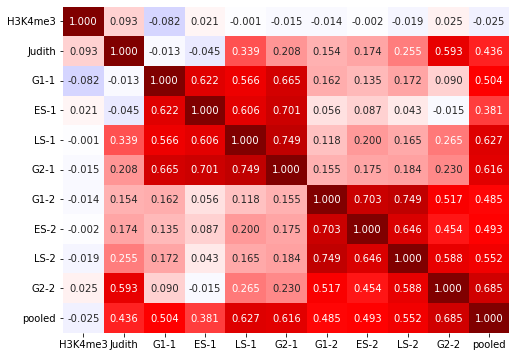

In [ ]:
column = "-log_qval"
df_H3K9me3_compare = pd.DataFrame(
    {"H3K4me3": df_H3K4me3[column], "Judith": df_H3K9me3[column]}
)
setups = np.array(
    [
        "H3K4me3",
        "Judith",
        "G1-1",
        "ES-1",
        "LS-1",
        "G2-1",
        "G1-2",
        "ES-2",
        "LS-2",
        "G2-2",
        "pooled",
    ]
)
for i in range(8):
    df_H3K9me3_compare[f"Rechem_{setups[i+1]}"] = H3K9me3_Rechem[i][column]
df_H3K9me3_compare["Rechem_pooled"] = df_Rechem_pooled[column]

corrs = np.corrcoef(df_H3K9me3_compare, rowvar=False)
plt.figure(figsize=(8, 6))
sns.heatmap(
    corrs,
    vmin=-1,
    vmax=1,
    annot=True,
    fmt=".3f",
    cmap=plt.cm.get_cmap("seismic"),
    cbar=False,
    xticklabels=setups,
    yticklabels=setups,
)

Autocorrelation

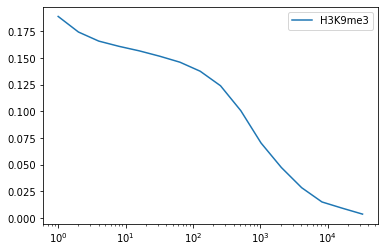

In [44]:
lags = 2 ** np.arange(16)
autocorrs_H3K9me3 = []
for lag in lags:
    autocorrs_H3K9me3.append(df["-log_qval"].astype(float).autocorr(lag=lag))
plt.plot(lags, autocorrs_H3K9me3, label="H3K9me3")
plt.xscale("log")
plt.legend()
plt.show()
plt.close()

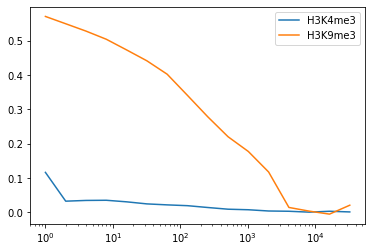

In [ ]:
lags = 2 ** np.arange(16)
autocorrs_H3K4me3 = []
autocorrs_H3K9me3 = []
for lag in lags:
    autocorrs_H3K4me3.append(df_H3K4me3["-log_qval"].astype(float).autocorr(lag=lag))
    autocorrs_H3K9me3.append(df_H3K9me3["-log_qval"].astype(float).autocorr(lag=lag))
plt.plot(lags, autocorrs_H3K4me3, label="H3K4me3")
plt.plot(lags, autocorrs_H3K9me3, label="H3K9me3")
plt.xscale("log")
plt.legend()
plt.show()
plt.close()

#### Old plots

Plot of raw signal

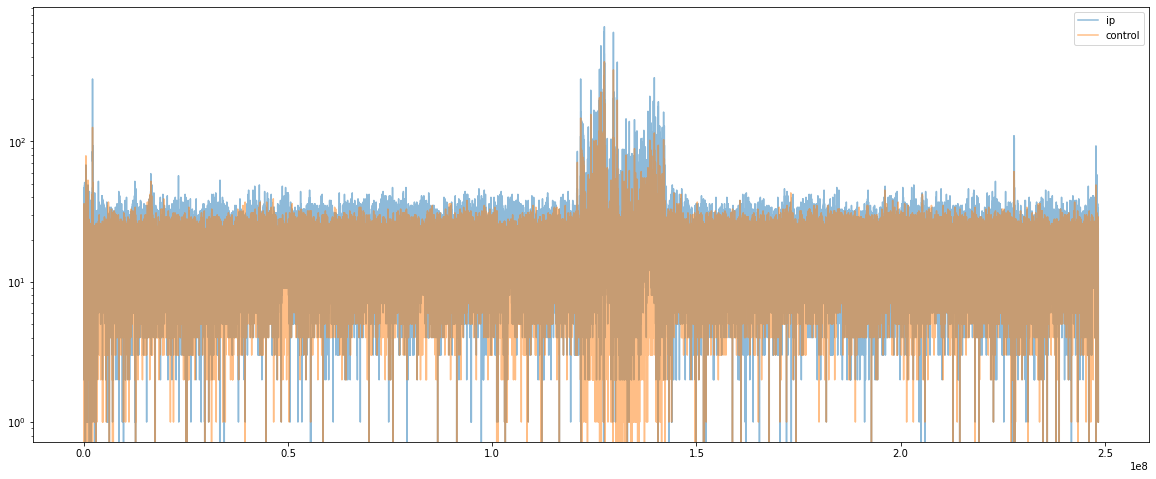

In [ ]:
start = 0  # 30_000_000
end = len(ip_binned_signal_chr) * bins
bin_start = (start // bins) * bins + bins // 2
bin_end = (end // bins) * bins + bins // 2
plt.figure(figsize=(20, 8))
plt.plot(
    np.arange(bin_start, bin_end, bins),
    ip_binned_signal_chr[start // bins : end // bins],
    label="ip",
    alpha=0.5,
)
plt.plot(
    np.arange(bin_start, bin_end, bins),
    ctrl_binned_signal_chr[start // bins : end // bins],
    label="control",
    alpha=0.5,
)
# plt.plot(np.arange(bin_start, bin_end, bins), ip2_binned_signal_chr[start//bins:end//bins], label='ip2', alpha=0.5)
# plt.plot(np.arange(bin_start, bin_end, bins), ctrl2_binned_signal_chr[start//bins:end//bins], label='control2', alpha=0.5)
# plt.plot(np.arange(bin_start, bin_end, bins), ctrl3_binned_signal_chr[start//bins:end//bins], label='control3', alpha=0.5)
plt.yscale("log")
plt.legend()
plt.show()
plt.close()

In [ ]:
data3 = "Judith-H3K27me3"
bins = 1000
chr_id = 1
df = pd.read_csv(
    f"{data_dir}/{data3}/results/All_chr{chr_id}_binned_{bins}.csv", index_col=0
)

<AxesSubplot:>

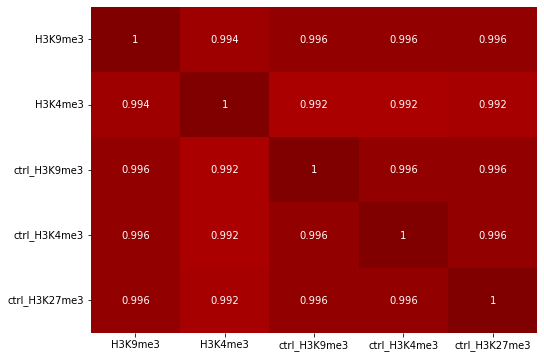

In [ ]:
corrs = np.corrcoef(df.iloc[:, 1:], rowvar=False)
plt.figure(figsize=(8, 6))
sns.heatmap(
    corrs,
    vmin=0.9,
    vmax=1,
    annot=True,
    fmt=".3g",
    cmap=plt.cm.get_cmap("seismic"),
    cbar=False,
    xticklabels=df.columns[1:],
    yticklabels=df.columns[1:],
)

Processed signals

In [ ]:
def KL(x, y):
    return x * np.log10(x / y)


df["KL_H3K4me3_ctrl4"] = KL(df["H3K4me3"], df["ctrl_H3K4me3"])
df["KL_H3K4me3_ctrl9"] = KL(df["H3K4me3"], df["ctrl_H3K9me3"])
df["KL_H3K4me3_ctrl27"] = KL(df["H3K4me3"], df["ctrl_H3K27me3"])
df["KL_H3K9me3_ctrl4"] = KL(df["H3K9me3"], df["ctrl_H3K4me3"])
df["KL_H3K9me3_ctrl9"] = KL(df["H3K9me3"], df["ctrl_H3K9me3"])
df["KL_H3K9me3_ctrl27"] = KL(df["H3K9me3"], df["ctrl_H3K27me3"])

/home/alex/anaconda3/envs/tf2.5/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


(230014, 12)
(230220, 12)


<AxesSubplot:>

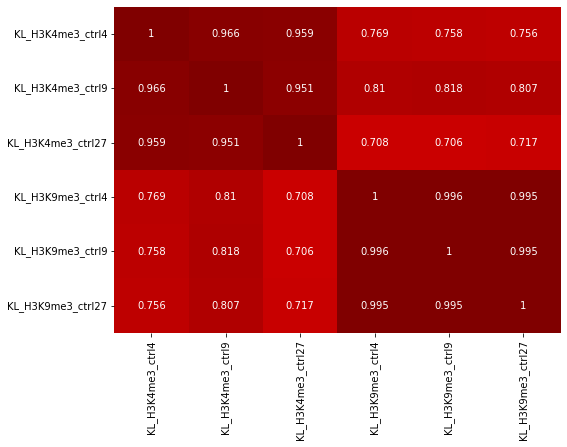

In [ ]:
df2 = df.where(np.isfinite(df)).dropna()
print(df2.shape)
print(df.shape)
corrs_processed = np.corrcoef(df2.iloc[:, 6:], rowvar=False)
plt.figure(figsize=(8, 6))
sns.heatmap(
    corrs_processed,
    vmin=-1,
    vmax=1,
    annot=True,
    fmt=".3g",
    cmap=plt.cm.get_cmap("seismic"),
    cbar=False,
    xticklabels=df2.columns[6:],
    yticklabels=df2.columns[6:],
)

/tmp/ipykernel_240455/2711071431.py:5: RuntimeWarning: divide by zero encountered in log10
  values_list = [log_ratio_chr, KL_chr, -np.log10(p_vals)]


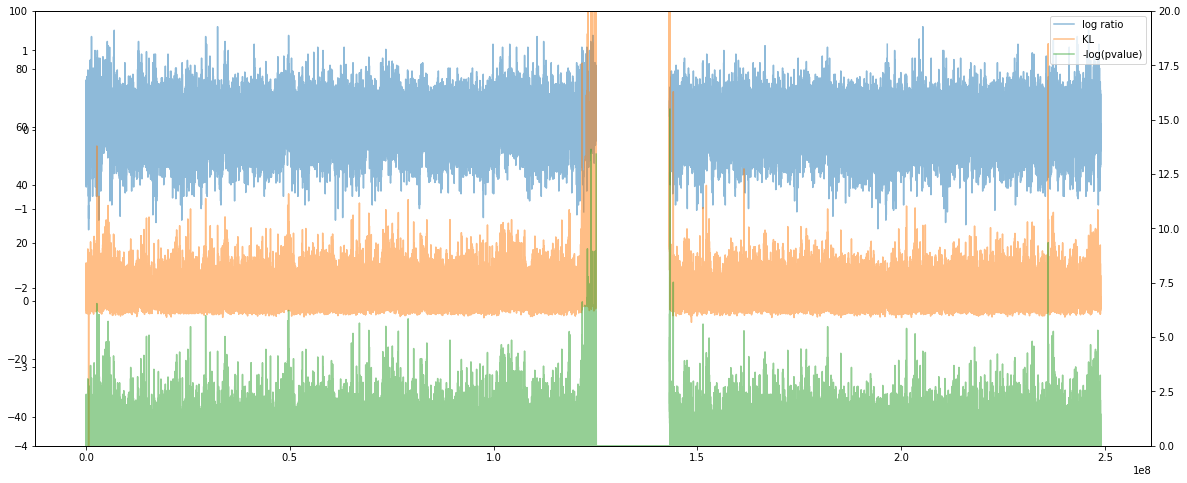

In [ ]:
importlib.reload(plot_utils)
start = 0  # 30_000_000
end = len(ip_binned_signal_chr) * bins
plt.figure(figsize=(20, 8))
values_list = [log_ratio_chr, KL_chr, -np.log10(p_vals)]
label_list = ["log ratio", "KL", "-log(pvalue)"]
axes = plot_utils.compare_binned_plots(
    values_list, label_list, start, end, bins, alpha=0.5
)
axes[0].set_ylim(bottom=-4, top=1.5)
axes[1].set_ylim(bottom=-50, top=100)
axes[2].set_ylim(bottom=0, top=20)
plt.show()
plt.close()

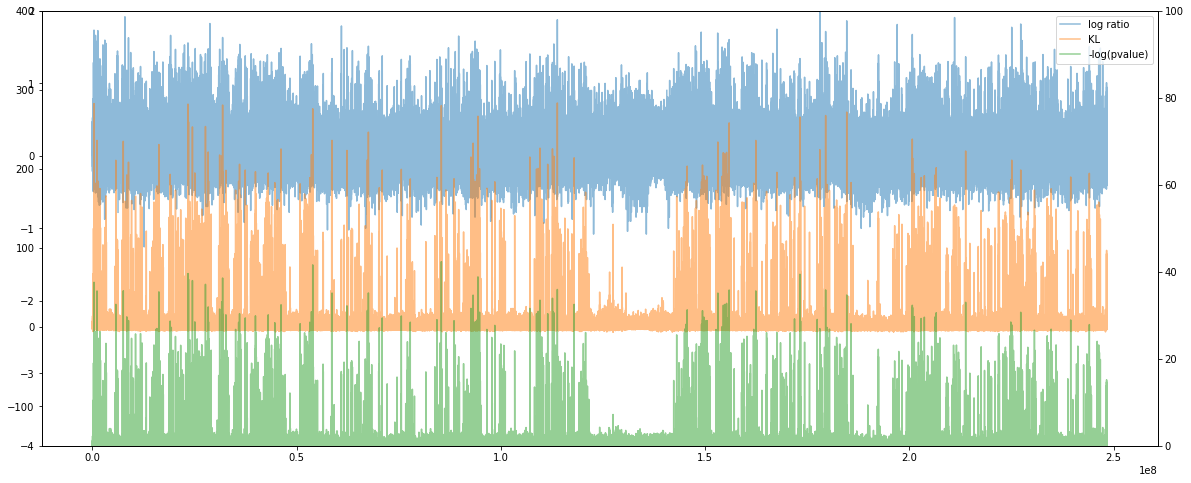

In [ ]:
importlib.reload(plot_utils)
start = 0  # 30_000_000
end = len(ip_binned_signal_chr) * bins
plt.figure(figsize=(20, 8))
values_list = [log_ratio_chr, KL_chr, -np.log10(p_vals)]
label_list = ["log ratio", "KL", "-log(pvalue)"]
axes = plot_utils.compare_binned_plots(
    values_list, label_list, start, end, bins, alpha=0.5
)
axes[0].set_ylim(bottom=-4, top=2)
axes[1].set_ylim(bottom=-150, top=400)
axes[2].set_ylim(bottom=0, top=100)
plt.show()
plt.close()

/home/alex/anaconda3/envs/tf2.5/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


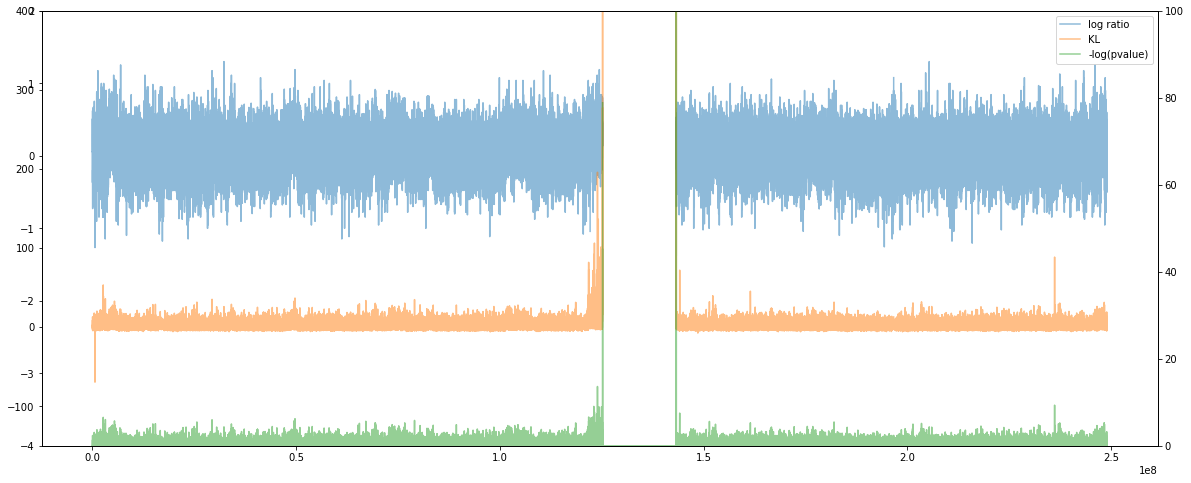

In [ ]:
data = "Judith-H3K9me3"
df = pd.read_csv(
    f"{data_dir}/{data}/results/alignments/GRCh38/{data}_chr{chr_id}_binned_{bins}.csv"
)
ip_binned_signal_chr = df["ip_binned_signal"]
log_ratio_chr = df["log_ratio"]
KL_chr = df["KL"]
p_vals = df["binom_p_value"]
start = 0  # 30_000_000
end = len(ip_binned_signal_chr) * bins
plt.figure(figsize=(20, 8))
values_list = [log_ratio_chr, KL_chr, -np.log10(p_vals)]
label_list = ["log ratio", "KL", "-log(pvalue)"]
axes = plot_utils.compare_binned_plots(
    values_list, label_list, start, end, bins, alpha=0.5
)
axes[0].set_ylim(bottom=-4, top=2)
axes[1].set_ylim(bottom=-150, top=400)
axes[2].set_ylim(bottom=0, top=100)
plt.show()
plt.close()

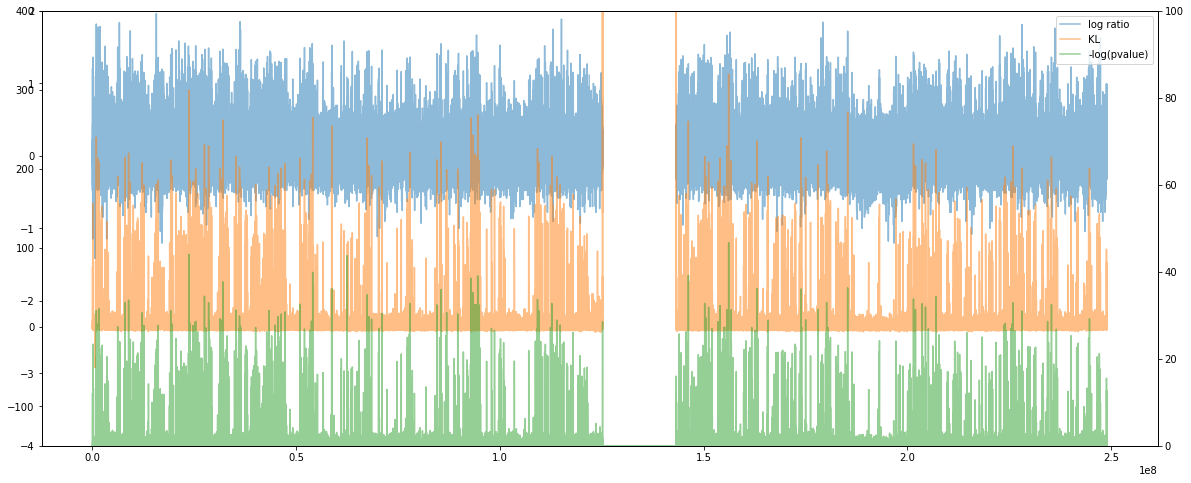

In [ ]:
data = "Judith-H3K4me3"
df = pd.read_csv(
    f"{data_dir}/{data}/results/alignments/GRCh38/{data}_chr{chr_id}_binned_{bins}.csv"
)
ip_binned_signal_chr = df["ip_binned_signal"]
log_ratio_chr = df["log_ratio"]
KL_chr = df["KL"]
p_vals = df["binom_p_value"]
start = 0  # 30_000_000
end = len(ip_binned_signal_chr) * bins
plt.figure(figsize=(20, 8))
values_list = [log_ratio_chr, KL_chr, -np.log10(p_vals)]
label_list = ["log ratio", "KL", "-log(pvalue)"]
axes = plot_utils.compare_binned_plots(
    values_list, label_list, start, end, bins, alpha=0.5
)
axes[0].set_ylim(bottom=-4, top=2)
axes[1].set_ylim(bottom=-150, top=400)
axes[2].set_ylim(bottom=0, top=100)
plt.show()
plt.close()

Correlation between processed signals

In [ ]:
valid_bins = np.logical_and(np.isfinite(KL_chr), np.isfinite(-np.log10(p_vals)))
print(pearsonr(KL_chr[valid_bins], -np.log10(p_vals)[valid_bins]))
print(pearsonr(KL_chr[valid_bins], log_ratio_chr[valid_bins]))
print(pearsonr(-np.log10(p_vals)[valid_bins], log_ratio_chr[valid_bins]))

(0.9912833207835683, 0.0)
(0.6653103968940027, 0.0)
(0.6056913679136753, 0.0)


Plot of processed signals

/tmp/ipykernel_126826/2145195069.py:11: RuntimeWarning: divide by zero encountered in log10
  ax3.plot(np.arange(bin_start, bin_end, bins), -np.log10(p_vals)[start//bins:end//bins], label='-log(pvalue)', alpha=0.5, color=colors[2])


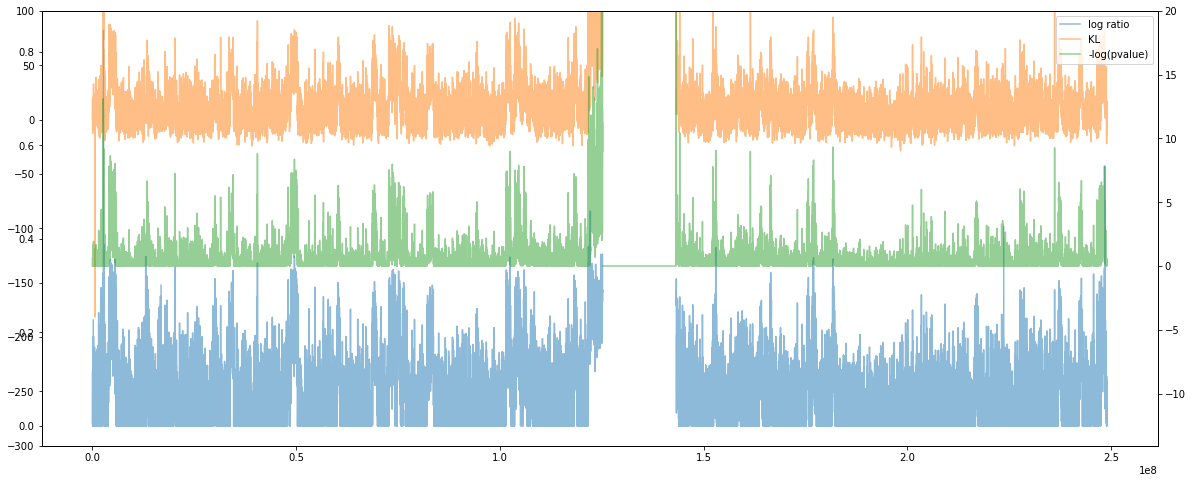

In [ ]:
start = 0  # 30_000_000
end = len(ip_binned_signal_chr) * bins
bin_start = (start // bins) * bins + bins // 2
bin_end = (end // bins) * bins + bins // 2
plt.figure(figsize=(20, 8))
ax1 = plt.subplot()
ax1.plot(
    np.arange(bin_start, bin_end, bins),
    np.maximum(log_ratio_chr[start // bins : end // bins], 0),
    label="log ratio",
    alpha=0.5,
)
ax2 = ax1.twinx()
ax2.plot(
    np.arange(bin_start, bin_end, bins),
    KL_chr[start // bins : end // bins],
    label="KL",
    alpha=0.5,
    color=colors[1],
)
ax3 = ax2.twinx()
ax3.plot(
    np.arange(bin_start, bin_end, bins),
    -np.log10(p_vals)[start // bins : end // bins],
    label="-log(pvalue)",
    alpha=0.5,
    color=colors[2],
)
# ax1.set_ylim(bottom=-1.5)
ax2.set_ylim(bottom=-300, top=100)
ax3.set_ylim(top=20)
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles3, labels3 = ax3.get_legend_handles_labels()
plt.legend(handles1 + handles2 + handles3, labels1 + labels2 + labels3)
plt.show()
plt.close()

/tmp/ipykernel_270277/2435503918.py:5: RuntimeWarning: divide by zero encountered in log
  N = np.log(ip_binned_signal_chr)
/tmp/ipykernel_270277/2435503918.py:8: RuntimeWarning: invalid value encountered in multiply
  plt.scatter(KL_chr[start//bins:end//bins], (-np.log10(p_vals)*N)[start//bins:end//bins], c=N, cmap='YlOrRd', label='positions', alpha=0.5)


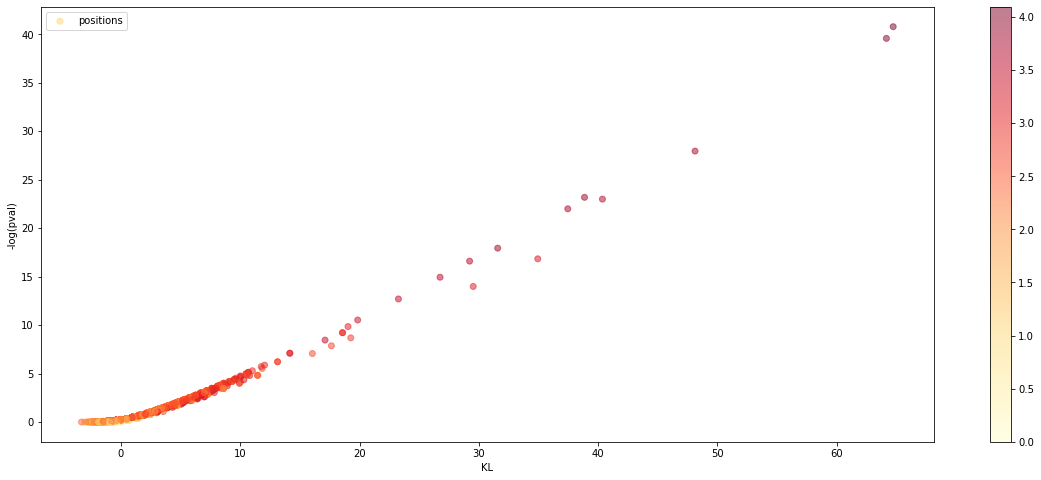

In [ ]:
start = 0  # 30_000_000
end = len(ip_binned_signal_chr) * bins
bin_start = (start // bins) * bins + bins // 2
bin_end = (end // bins) * bins + bins // 2
N = np.log(ip_binned_signal_chr)
plt.figure(figsize=(20, 8))
# ax1 = plt.subplot()
plt.scatter(
    KL_chr[start // bins : end // bins],
    (-np.log10(p_vals) * N)[start // bins : end // bins],
    c=N,
    cmap="YlOrRd",
    label="positions",
    alpha=0.5,
)
# plt.xlim(left=0, right=200)
# plt.ylim(bottom=0, top=15)
plt.xlabel("KL")
plt.ylabel("-log(pval)")
plt.legend()
plt.colorbar()
plt.show()
plt.close()

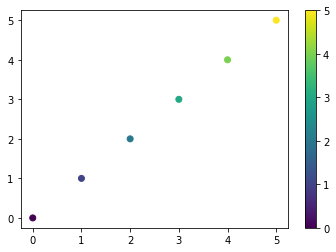

In [ ]:
x = np.arange(6)
plt.scatter(x, x, c=x)
plt.colorbar()

#### Exact alignment

In [ ]:
ip_signal_chr = utils.exact_alignment_signal_from_coord(ip_coord_chr)
ctrl_signal_chr = utils.exact_alignment_signal_from_coord(ctrl_coord_chr)
print(len(ip_signal_chr), len(ctrl_signal_chr))
ip_signal_chr, ctrl_signal_chr = utils.adjust_length(ip_signal_chr, ctrl_signal_chr)
print(len(ip_signal_chr), len(ctrl_signal_chr))

248946395 248946413
248946413 248946413


In [ ]:
ip_postbinned_signal_chr = convolve(ip_signal_chr, np.ones(bins) / bins, mode="same")
ctrl_postbinned_signal_chr = convolve(
    ctrl_signal_chr, np.ones(bins) / bins, mode="same"
)

In [ ]:
postbinned_log_ratio_chr = np.log10(
    ip_postbinned_signal_chr / ctrl_postbinned_signal_chr
)
postbinned_KL_chr = ip_postbinned_signal_chr * np.log10(
    ip_postbinned_signal_chr / ctrl_postbinned_signal_chr
)

# p_binom = len(ip_coord_chr) / (len(ip_coord_chr) + len(ctrl_coord_chr))
# p_vals = np.zeros(len(ip_postbinned_signal_chr))
# for i in range(len(ip_postbinned_signal_chr)):
#     n_binom = ip_postbinned_signal_chr[i] + ctrl_postbinned_signal_chr[i]
#     k_binom = ip_postbinned_signal_chr[i]
#     if n_binom >= 1:
#         res = scipy.stats.binomtest(k_binom, n_binom, p=p_binom, alternative='greater')
#         p_vals[i] = res.pvalue
#     else:
#         p_vals[i] = 1

/tmp/ipykernel_122611/899252405.py:1: RuntimeWarning: divide by zero encountered in true_divide
  postbinned_log_ratio_chr = np.log10(ip_postbinned_signal_chr / ctrl_postbinned_signal_chr)
/tmp/ipykernel_122611/899252405.py:1: RuntimeWarning: invalid value encountered in true_divide
  postbinned_log_ratio_chr = np.log10(ip_postbinned_signal_chr / ctrl_postbinned_signal_chr)
/tmp/ipykernel_122611/899252405.py:1: RuntimeWarning: divide by zero encountered in log10
  postbinned_log_ratio_chr = np.log10(ip_postbinned_signal_chr / ctrl_postbinned_signal_chr)
/tmp/ipykernel_122611/899252405.py:1: RuntimeWarning: invalid value encountered in log10
  postbinned_log_ratio_chr = np.log10(ip_postbinned_signal_chr / ctrl_postbinned_signal_chr)
/tmp/ipykernel_122611/899252405.py:2: RuntimeWarning: divide by zero encountered in true_divide
  postbinned_KL_chr = ip_postbinned_signal_chr * np.log10(ip_postbinned_signal_chr / ctrl_postbinned_signal_chr)
/tmp/ipykernel_122611/899252405.py:2: RuntimeWarn

In [ ]:
start = 0  # 122_000_000
end = len(ip_signal_chr)  # 40_000_000
plt.figure(figsize=(20, 8))
ax1 = plt.subplot()
ax1.plot(
    np.arange(start, end), ip_postbinned_signal_chr[start:end], label="ip", alpha=0.5
)
repeats = utils.find_peaks_in_window(all_chr_repeats, start, end)
print(repeats.shape)
rep_height = 1
for id, (rep_start, rep_end, *_) in enumerate(repeats):
    if id == 0:
        ax1.plot(
            [rep_start, rep_end],
            [rep_height, rep_height],
            marker=".",
            color="red",
            label="repeats",
        )
    else:
        ax1.plot(
            [rep_start, rep_end], [rep_height, rep_height], marker=".", color="red"
        )
# plt.plot(np.arange(start, end), ctrl_signal_chr[start:end], label='control', alpha=0.5)
ax1.set_yscale("log")
# handles1, labels1 = ax1.get_legend_handles_labels()
plt.legend(loc="upper right")
plt.show()
plt.close()

(444217, 2)


: 

: 

## Tests

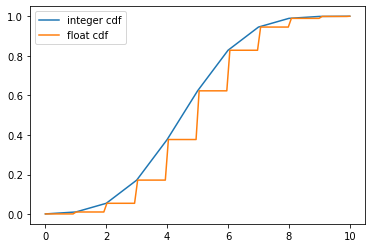

In [ ]:
res_int = scipy.stats.binom.cdf(np.linspace(0, 10, 11), 10, 0.5)
res_nonint = scipy.stats.binom.cdf(np.linspace(0, 10, 100), 10, 0.5)
plt.plot(np.linspace(0, 10, 11), res_int, label="integer cdf")
plt.plot(np.linspace(0, 10, 100), res_nonint, label="float cdf")
plt.legend()
plt.show()
plt.close()

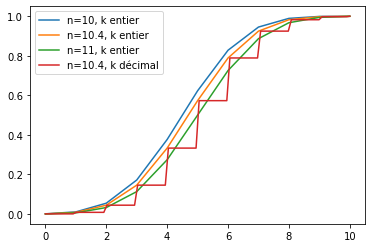

In [ ]:
res_int = scipy.stats.binom.cdf(np.linspace(0, 10, 11), 10, 0.5)
res_nonint = scipy.stats.binom.cdf(np.linspace(0, 10, 11), 10.4, 0.5)
res_int2 = scipy.stats.binom.cdf(np.linspace(0, 10, 11), 11, 0.5)
res_nonint2 = scipy.stats.binom.cdf(np.linspace(0, 10, 100), 10.4, 0.5)
plt.plot(np.linspace(0, 10, 11), res_int, label="n=10, k entier")
plt.plot(np.linspace(0, 10, 11), res_nonint, label="n=10.4, k entier")
plt.plot(np.linspace(0, 10, 11), res_int2, label="n=11, k entier")
plt.plot(np.linspace(0, 10, 100), res_nonint2, label="n=10.4, k décimal")
plt.legend()
plt.show()
plt.close()

In [ ]:
def fdr_bh(p):
    q = np.copy(p)
    # sort
    order = np.argsort(q)
    q = q[order]
    # compute p_value correction
    q = np.minimum(q * len(q) / np.arange(1, len(q) + 1), 1)
    # preserve order by taking min of upper values
    q[::-1] = np.minimum.accumulate(q[::-1])
    # unsort before output
    return q[np.argsort(order)]


my_qval_H3K4me3 = fdr_bh(df_H3K4me3["pval"])

assert np.allclose(my_qval_H3K4me3, df_H3K4me3["qval"])

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(df_H3K4me3["qval"], my_qval_H3K4me3)
plt.xlabel("scipy's q_value implementation", fontsize=14)
plt.ylabel("my q_value implementation", fontsize=14)
# plt.xscale('log')
# plt.yscale('log')
plt.show()
plt.close()